In [1]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri
import pymc as pm
import seaborn as sns
import arviz
from scipy import stats
import math
import textwrap
import os
os.makedirs("plots", exist_ok=True)
import logging
logger = logging.getLogger("pymc")
logger.setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', message='Using NumPy C-API based implementation for BLAS functions.')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
FIGURES = []

In [3]:
def get_data():

    numpy2ri.activate()

    importr('boot')

    robjects.r('''
    library(boot)
    data(coal)
    x <- 1851:1962
    y <- tabulate(floor(coal[[1]]))
    y <- y[x]
    ''')

    x = robjects.r['x']
    y = robjects.r['y']

    with localconverter(robjects.default_converter + numpy2ri.converter):
        x = np.array(x)
        y = np.array(y)
    
    return x, y

In [4]:
def plot_data(x, y):
    
    plt.figure(figsize=(7, 5))
    
    plt.plot(x, np.cumsum(y))
    
    plt.ylabel("Cumulative number of disasters")
    plt.xlabel("Year");
    
    plt.xticks(np.linspace(x[0], x[-1], 8, dtype=np.int32)) 
    plt.grid(True, which='major', color='lightgrey', linestyle='--', linewidth=0.5)

    FIGURES.append(len(FIGURES)+1)
    plt.figtext(
        0.5, 
        -0.1, 
        textwrap.fill(
            "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Cumulative number of UK yearly coal mining disasters against the years between 1851 and 1962. The rate of mining disasters seems to change three times; first around 1890, then around 1927, and finally around 1947.", 
            85,
        ), 
        fontsize=10,
        ha='center',
    )

    plt.savefig("plots/data_plot.png", bbox_inches='tight')
    plt.show()

In [5]:
def plot_fit(ax_obj, y, y_pred, T_maps=None):
    
    assert y_pred.ndim in [2, 3]
    if y_pred.ndim == 3:
        y_pred = y_pred[0]

    orig_data = np.cumsum(y)
    data = np.cumsum(y_pred, axis=-1)

    median_observation = np.median(data, axis=0)

    quantile_2_5 = np.percentile(data, 2.5, axis=0)
    quantile_97_5 = np.percentile(data, 97.5, axis=0)

    timeline = np.arange(data.shape[1])
    
    ax_obj.plot(timeline, median_observation, label='Prediction Median', color='red')
    ax_obj.fill_between(timeline, quantile_2_5, quantile_97_5, color='green', alpha=0.3, label='95% Prediction Interval')
    ax_obj.plot(timeline, orig_data, label='Observations', color='black', linestyle='--')

    ax_obj.set_xlabel('Year')
    ax_obj.set_ylabel('Cumulative number of disasters')
    
    ax_obj.set_xticks(ticks=np.linspace(0, 112, num=6))
    ax_obj.set_xticklabels(labels=np.linspace(1851, 1963, num=6, dtype=int))
    ax_obj.legend(loc='upper left')
    ax_obj.grid(False)
    
    if T_maps is not None:
        for i in range(len(T_maps)):
            xlim = ax_obj.get_xlim()
            ylim = ax_obj.get_ylim()
            xpos = xlim[1] * 0.95
            ypos = ylim[0] + 14*(len(T_maps)-i)
            ax_obj.text(xpos, ypos, f'MAP($T_{i+1}$) = {T_maps[f"T{i+1}"]}', horizontalalignment='right', verticalalignment='bottom', fontsize=12)

In [6]:
def get_eval_metric(trace_tree):
    
    trace_ = pm.to_inference_data(trace_tree)
    
    rhat = arviz.rhat(trace_)
    rhat_max = max(val.max() for val in rhat.values())
    
    return rhat_max.item()

In [7]:
def run_0changepoint_model(data):
    
    with pm.Model() as model:

        lambda_ = pm.Gamma('lambda_1', mu=2, sigma=1)
        
        observations = pm.Poisson('obs', mu=lambda_, observed=data)
        
        trace = pm.sample_smc(
            5000, 
            kernel=pm.smc.kernels.MH,
            threshold=1e-20,
            return_inferencedata=False, 
            progressbar=False,
            random_seed=101,
        )

        posterior_predictive = pm.sample_posterior_predictive(
            trace, 
            return_inferencedata=False, 
            progressbar=False,
            random_seed=101,
        )
 
        return trace, posterior_predictive, get_eval_metric(trace)

In [8]:
def run_1changepoint_model(data):
    
    with pm.Model() as model:

        lambda_1 = pm.Gamma('lambda_1', 2, 1)
        lambda_2 = pm.Gamma('lambda_2', 2, 1)
        
        T1 = pm.DiscreteUniform('T1', lower=1851, upper=1962)
        
        idx = np.arange(1851, 1963)
        lambda_ = pm.math.switch(T1 >= idx, lambda_1, lambda_2)
        
        observations = pm.Poisson('obs', mu=lambda_, observed=data)
        
        trace = pm.sample_smc(
            5000, 
            kernel=pm.smc.kernels.MH,
            threshold=1e-20,
            return_inferencedata=False, 
            progressbar=False,
            random_seed=101,
        )

        posterior_predictive = pm.sample_posterior_predictive(
            trace, 
            return_inferencedata=False, 
            progressbar=False,
            random_seed=101,
        )

        return trace, posterior_predictive, get_eval_metric(trace)

In [9]:
def run_2changepoint_model(data):

    with pm.Model() as model:
        
        lambda_1 = pm.Gamma('lambda_1', 2, 1)
        lambda_2 = pm.Gamma('lambda_2', 2, 1)
        lambda_3 = pm.Gamma('lambda_3', 2, 1)

        T1 = pm.DiscreteUniform('T1', lower=1851, upper=1961)
        T2 = pm.DiscreteUniform('T2', lower=T1 + 1, upper=1962)

        idx = np.arange(1851, 1963)
        lambda_ = pm.math.switch(T2 >= idx, 
                pm.math.switch(T1 >= idx, lambda_1, lambda_2), 
                lambda_3)

        observations = pm.Poisson('obs', mu=lambda_, observed=data)

        trace = pm.sample_smc(
            5000, 
            kernel=pm.smc.kernels.MH,
            correlation_threshold=0.005,
            return_inferencedata=False, 
            progressbar=False,
            random_seed=101,
        )

        posterior_predictive = pm.sample_posterior_predictive(
            trace, 
            return_inferencedata=False, 
            progressbar=False,
            random_seed=101,
        )
  
        return trace, posterior_predictive, get_eval_metric(trace)

In [10]:
def run_3changepoint_model(data):

    with pm.Model() as model:
        
        lambda_1 = pm.Gamma('lambda_1', 2, 1)
        lambda_2 = pm.Gamma('lambda_2', 2, 1)
        lambda_3 = pm.Gamma('lambda_3', 2, 1)
        lambda_4 = pm.Gamma('lambda_4', 2, 1)

        T1 = pm.DiscreteUniform('T1', lower=1851, upper=1960)
        T2 = pm.DiscreteUniform('T2', lower=T1 + 1, upper=1961)
        T3 = pm.DiscreteUniform('T3', lower=T2 + 1, upper=1962)

        idx = np.arange(1851, 1963)
        lambda_ = pm.math.switch(T3 >= idx, 
                    pm.math.switch(T2 >= idx, 
                        pm.math.switch(T1 >= idx, lambda_1, lambda_2), 
                        lambda_3),
                    lambda_4)
        
        observations = pm.Poisson('obs', mu=lambda_, observed=data)

        trace = pm.sample_smc(
            5000, 
            kernel=pm.smc.kernels.MH,
            correlation_threshold=0.0001,
            return_inferencedata=False, 
            progressbar=False,
            random_seed=100,
        )

        posterior_predictive = pm.sample_posterior_predictive(
            trace, 
            return_inferencedata=False, 
            progressbar=False,
            random_seed=100,
        )

        return trace, posterior_predictive, get_eval_metric(trace)

In [11]:
def run_4changepoint_model(data):
    
    with pm.Model() as model:
        
        lambda_1 = pm.Gamma('lambda_1', 2, 1)
        lambda_2 = pm.Gamma('lambda_2', 2, 1)
        lambda_3 = pm.Gamma('lambda_3', 2, 1)
        lambda_4 = pm.Gamma('lambda_4', 2, 1)
        lambda_5 = pm.Gamma('lambda_5', 2, 1)

        T1 = pm.DiscreteUniform('T1', lower=1851, upper=1959)
        T2 = pm.DiscreteUniform('T2', lower=T1 + 1, upper=1960)
        T3 = pm.DiscreteUniform('T3', lower=T2 + 1, upper=1961)
        T4 = pm.DiscreteUniform('T4', lower=T3 + 1, upper=1962)

        idx = np.arange(1851, 1963)
        lambda_ = pm.math.switch(T4 >= idx, 
                    pm.math.switch(T3 >= idx, 
                        pm.math.switch(T2 >= idx, 
                            pm.math.switch(T1 >= idx, lambda_1, lambda_2), 
                            lambda_3),
                        lambda_4),
                    lambda_5)
        
        observations = pm.Poisson('obs', mu=lambda_, observed=data)

        trace = pm.sample_smc(
            5000, 
            kernel=pm.smc.kernels.MH,
            correlation_threshold=0.000001,
            return_inferencedata=False, 
            progressbar=False,
            random_seed=90,
        )

        posterior_predictive = pm.sample_posterior_predictive(
            trace, 
            return_inferencedata=False, 
            progressbar=False,
            random_seed=90,
        )
 
        return trace, posterior_predictive, get_eval_metric(trace)

In [12]:
def model_n_plots(trace, modes, y=None, y_pred=None):

    trace_varnames = [var for var in trace.varnames if "log" not in var]
    varnames = trace_varnames.copy()
    for i, string in enumerate(trace_varnames):
        if 'lambda_' in string:
            varnames[i] = '${}$'.format(string.replace('lambda', '\lambda'))
        elif 'T' in string:
            varnames[i] = '$' + string[0] + '_' + string[1] + '$'
    
    lambdas = [trace.get_values(var, chains=0) for var in trace_varnames if "lambda" in var]
    Ts = [trace.get_values(var, chains=0) for var in trace_varnames if "T" in var]
    n_points = len(Ts)

    if n_points == 0:
    
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    
        prior_x = np.linspace(0, 4, 1000)
        prior = stats.gamma(a=2, scale=1.0).pdf(prior_x)
        ax1.plot(prior_x, prior)
        ax1.set_xlabel('$\lambda$')
        ax1.set_ylabel('Prior Density')
        ax1.set_title('A')
        
        sns.kdeplot(trace['lambda_1'], ax=ax2)
        ax2.set_xlim(0, 4)
        ax2.set_ylim(-0.05, 3.5)
        ax2.set_xlabel('$\lambda$')
        ax2.set_ylabel('Posterior Density')
        ax2.set_title('B')

        plot_fit(ax3, y, y_pred)
        ax3.set_title('C')

        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.07, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Inference and prediction results for a model with no change-points. Panel A shows the prior for the rate parameter $\lambda$. Panel B shows the corresponding posterior. The peak at " + str(modes['lambda_1']) + " indicates the most likely value of $\lambda$. Panel C depicts the posterior predictive distribution alongside the observed data. This model does not explain the data well.", 
                210,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model0_fig"+str(FIGURES[-1])+".png", bbox_inches='tight')
        plt.show()

    elif n_points == 1:
        
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))
        for i, (ax, seq) in enumerate(zip(axs[:-1], lambdas)):
            sns.kdeplot(seq, ax=ax, fill=True)
            ax.set_ylabel('Posterior Density')
            ax.set_xlabel(f'$\lambda_{i+1}$')
        sns.histplot(Ts[0], ax=axs[-1], binwidth=1)
        axs[-1].set_ylabel('Posterior Density')
        axs[-1].set_xlabel(f'$T_1$')
        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.23, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior distributions for a model with one change-point. Strong peaks in the density plots indicate what the rate of the yearly number of coal mining disasters is likely to be for the corresponding segment. Likewise, strong spikes in the histogram plot indicate the most likely change-point location. According to the mode of the joint distribution of all parameters for this model, their most likely values are:  $\lambda_1$ = " + str(modes['lambda_1']) + ", $\lambda_2$ = " + str(modes['lambda_2']) + ", and $T_1$ = " + str(modes['T1']) + ".", 
                140,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model1_fig"+str(FIGURES[-1])+".png", bbox_inches='tight')
        plt.show()

    elif n_points == 2:
        
        fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))
        for i, (ax, seq) in enumerate(zip(axs, Ts)):
            sns.histplot(seq, ax=ax, binwidth=1)
            ax.set_ylabel('Posterior Density')
            ax.set_xlabel(f'$T_{i+1}$')
        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.16, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior distributions of the $T$ parameters for a model with two change-points. According to the mode of the joint distribution of all parameters for this model, the most likely values for the $T$ parameters are: $T_1$ = " + str(modes['T1'])+ ", and $T_2$ = " + str(modes['T2']) + ".", 
                120,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model2_fig"+str(FIGURES[-1])+"_Ts.png", bbox_inches='tight')
        plt.show()

        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        for i, (ax, seq) in enumerate(zip(axs, lambdas)):
            sns.kdeplot(seq, ax=ax, fill=True)
            ax.set_ylabel('Posterior Density')
            ax.set_xlabel(f'$\lambda_{i+1}$')
        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.2, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior distributions of the $\lambda$ parameters for a model with two change-points. According to the mode of the joint distribution of all parameters for this model, the most likely values for the $\lambda$ parameters are: $\lambda_1$ = " + str(modes['lambda_1']) + ", $\lambda_2$ = " + str(modes['lambda_2']) + ", and $\lambda_3$ = " + str(modes['lambda_3']) + ".", 
                135,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model2_fig"+str(FIGURES[-1])+"_lambdas.png", bbox_inches='tight')
        plt.show()

    elif n_points == 3:
        
        fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
        for i, (ax, seq) in enumerate(zip(axs, Ts)):
            sns.histplot(seq, ax=ax, binwidth=1)
            ax.set_ylabel('Posterior Density')
            ax.set_xlabel(f'$T_{i+1}$')
        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.12, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior distributions of the $T$ parameters for a model with three change-points. According to the mode of the joint distribution of all parameters for this model, the most likely values for the $T$ parameters are: $T_1$ = " + str(modes['T1']) + ", $T_2$ = " + str(modes['T2']) + ", and $T_3$ = " + str(modes['T3']) + ".", 
                150,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model3_fig"+str(FIGURES[-1])+"_Ts.png", bbox_inches='tight')
        plt.show()

        fig, axs = plt.subplots(2, 2, figsize=(9, 5.5))
        for i in range(2):
            for j in range(2):
                index = i * 2 + j
                sns.kdeplot(lambdas[index], ax=axs[i, j], fill=True)
                axs[i, j].set_title('')
                axs[i, j].set_xlabel(f'$\lambda_{index+1}$')
                axs[i, j].set_ylabel('Posterior Density')
        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.11, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior distributions of the $\lambda$ parameters for a model with three change-points. According to the mode of the joint distribution of all parameters for this model, the most likely values for the $\lambda$ parameters are: $\lambda_1$ = " + str(modes['lambda_1']) + ", $\lambda_2$ = " + str(modes['lambda_2']) + ", $\lambda_3$ = " + str(modes['lambda_3']) + ", and $\lambda_4$ = " + str(modes['lambda_4'],) + ".", 
                130,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model3_fig"+str(FIGURES[-1])+"_lambdas.png", bbox_inches='tight')
        plt.show()
        
    elif n_points == 4:
        
        fig, axs = plt.subplots(2, 2, figsize=(9, 6))
        for i in range(2):
            for j in range(2):
                index = i * 2 + j
                sns.histplot(Ts[index], ax=axs[i, j], binwidth=1)
                axs[i, j].set_title('')
                axs[i, j].set_xlabel(f'$T_{index+1}$')
                axs[i, j].set_ylabel('Posterior Density')
        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.1, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior distributions of the $T$ parameters for a model with four change-points. According to the mode of the joint distribution of all parameters for this model, the most likely values for the $T$ parameters are: $T_1$ = " + str(modes['T1']) + ", $T_2$ = " + str(modes['T2']) + ", $T_3$ = " + str(modes['T3']) + ", and $T_4$ = " + str(modes['T4']) + ".", 
                130,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model4_fig"+str(FIGURES[-1])+"_Ts.png", bbox_inches='tight')
        plt.show()
        
        fig, axs = plt.subplots(3, 2, figsize=(8, 7))
        fig.delaxes(axs[2,1])
        for i in range(3):
            for j in range(2):
                if i==2 and j==1:
                    break
                index = i * 2 + j
                sns.kdeplot(lambdas[index], ax=axs[i, j], fill=True)
                axs[i, j].set_title('')
                axs[i, j].set_xlabel(f'$\lambda_{index+1}$')
                axs[i, j].set_ylabel('Posterior Density')
        plt.tight_layout()
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.08, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior distributions of the $\lambda$ parameters for a model with four change-points. According to the mode of the joint distribution of all parameters for this model, the most likely values for the $\lambda$ parameters are: $\lambda_1$ = " + str(modes['lambda_1']) + ", $\lambda_2$ = " + str(modes['lambda_2']) + ", $\lambda_3$ = " + str(modes['lambda_3']) + ", $\lambda_4$ = " + str(modes['lambda_4']) + ", and $\lambda_5$ = " + str(modes['lambda_5'],) + ".", 
                120,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig("plots/model4_fig"+str(FIGURES[-1])+"_lambdas.png", bbox_inches='tight')
        plt.show()
        
    for trace_var, var in zip(trace_varnames, varnames):
        n_chains = trace.nchains
        colors = np.flipud(plt.cm.viridis(np.linspace(0, 1, n_chains)))
        plt.figure(figsize=(20, 6))
        for i in range(n_chains):
            plt.plot(trace.get_values(trace_var, chains=i), color=colors[i], label=f'Chain {i}', alpha=0.2)
        plt.xlim(-100, 5100)
        plt.xlabel('Iteration')
        plt.ylabel(var)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        FIGURES.append(len(FIGURES)+1)
        plt.figtext(
            0.5, 
            -0.01, 
            textwrap.fill(
                "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: " + f"Trace paths of {var} for a model with " + str(n_points) + " change-point" + ("s" if n_points!=1 else "") + ".", 
                100,
            ), 
            fontsize=10,
            ha='center',
        )
        plt.savefig(f"plots/model{n_points}_fig"+str(FIGURES[-1])+"_{trace_var}_chains.png", bbox_inches='tight')
        plt.show()

In [13]:
def plot_predictions(y, y_preds, modes):

    T_maps = [
        {var: value for var, value in mode.items() if 'T' in var}
        for mode in modes
    ]
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 7))

    for i in range(2):
        for j in range(2):
            index = i * 2 + j
            plot_fit(axs[i, j], y, y_preds[index], T_maps=T_maps[index])
            axs[i, j].set_title(chr(ord('@')+index+1))

    plt.tight_layout()
    
    FIGURES.append(len(FIGURES)+1)
    plt.figtext(
        0.5, 
        -0.07, 
        textwrap.fill(
            "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Posterior predictive distributions for models with one change-point (A), two change-points (B), three change-points (C), and four change-points (D). More complex models explain data better, but they must be penalized for complexity.", 
            100,
        ), 
        fontsize=10,
        ha='center',
    )

    plt.savefig("plots/predictions.png", bbox_inches='tight')
    plt.show()

In [14]:
def plot_marginals(marginals):
    
    plt.figure(figsize=(4, 3))
    sns.barplot(x=np.arange(len(marginals)), y=marginals)
    plt.title('')
    plt.xlabel('Number of change-points considered')
    plt.ylabel('Marginal likelihood for a model')    
    
    FIGURES.append(len(FIGURES)+1)
    plt.figtext(
        1.2, 
        0.15, 
        textwrap.fill(
            "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: Marginal likelihoods for models with different number of change-points considered. The marginals for a higher number of change-points are expected to monotonically decrease. The figure indicates a small number of change-points would be most suitable to explain our data. Most likely choices are three or four change-points.", 
            30,
        ), 
        fontsize=10,
        ha='center',
    )

    plt.savefig("plots/marginals.png", bbox_inches='tight')
    plt.show()

In [15]:
def plot_metric(rhat):
    
    plt.figure(figsize=(4, 3))
    
    sns.barplot(y=rhat, x=range(len(rhat)))
    plt.ylabel('$ \hat{R} $ statistic')
    plt.xlabel('Number of change-points considered')
    plt.axhline(y=1, color='g', linestyle='--')
    
    FIGURES.append(len(FIGURES)+1)
    plt.figtext(
        1.2, 
        0.25, 
        textwrap.fill(
            "$\\bf{Figure \: " + str(FIGURES[-1]) + "}$: The R-hat statistic for all models (maximum value across all parameters). It appears to be much lower than 1.05, for all parameters. This indicates there were no problems during sampling and the results are reliable.", 
            30,
        ), 
        fontsize=10,
        ha='center',
    )

    plt.savefig("plots/rhat.png", bbox_inches='tight')
    plt.show() 

In [16]:
def get_joint_mode(trace):
        
    vars = [var for var in trace.varnames if "log" not in var]

    samples = np.vstack([trace.get_values(var) for var in vars])
    
    densities = stats.gaussian_kde(samples)(samples)
    
    mode_index = np.argmax(densities)
    mode_sample = samples[:, mode_index]

    return {
        var: round(mode_sample[i], 1) if 'lambda' in var else int(mode_sample[i]) 
        for i, var in enumerate(vars)
    }

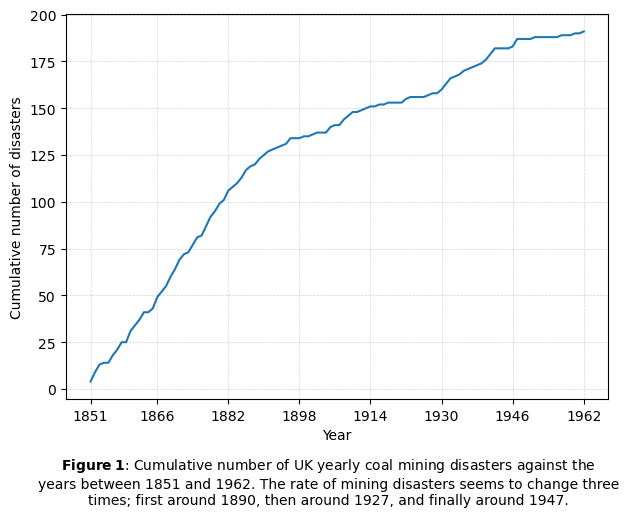

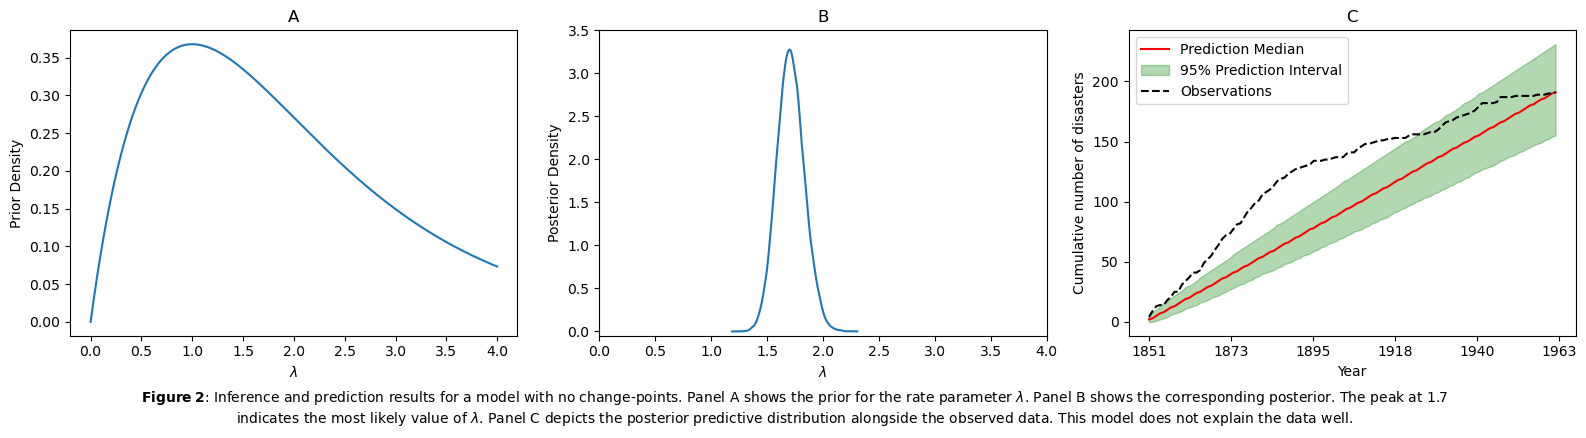

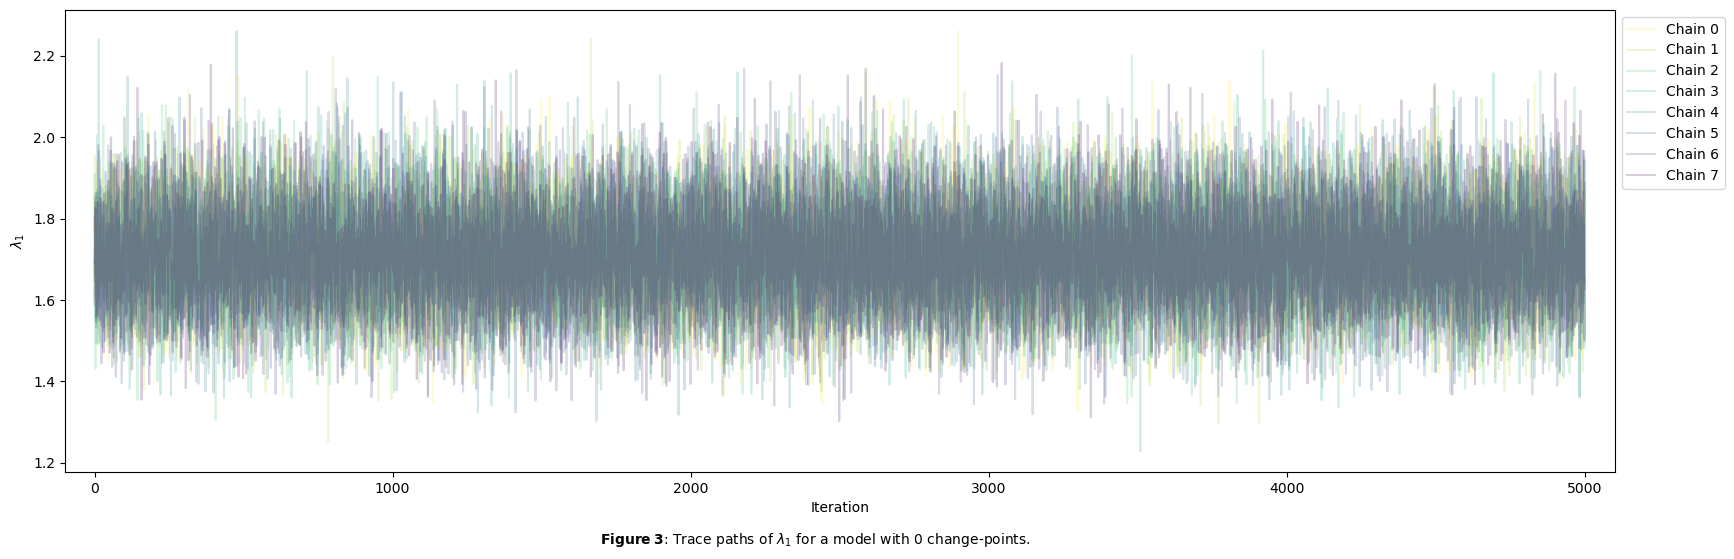

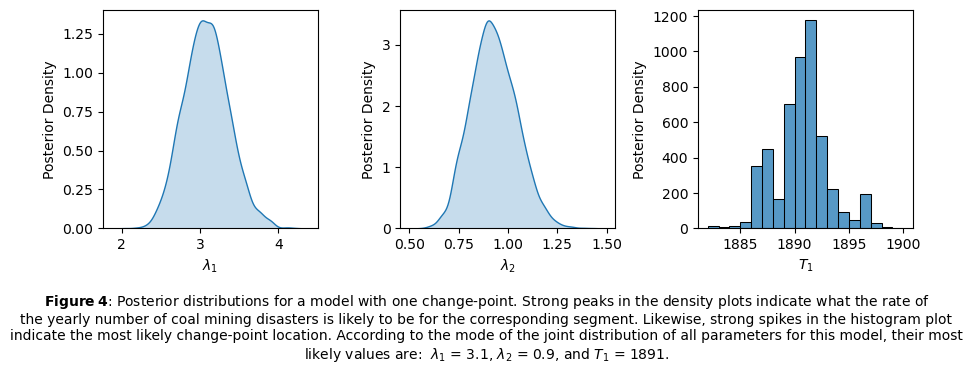

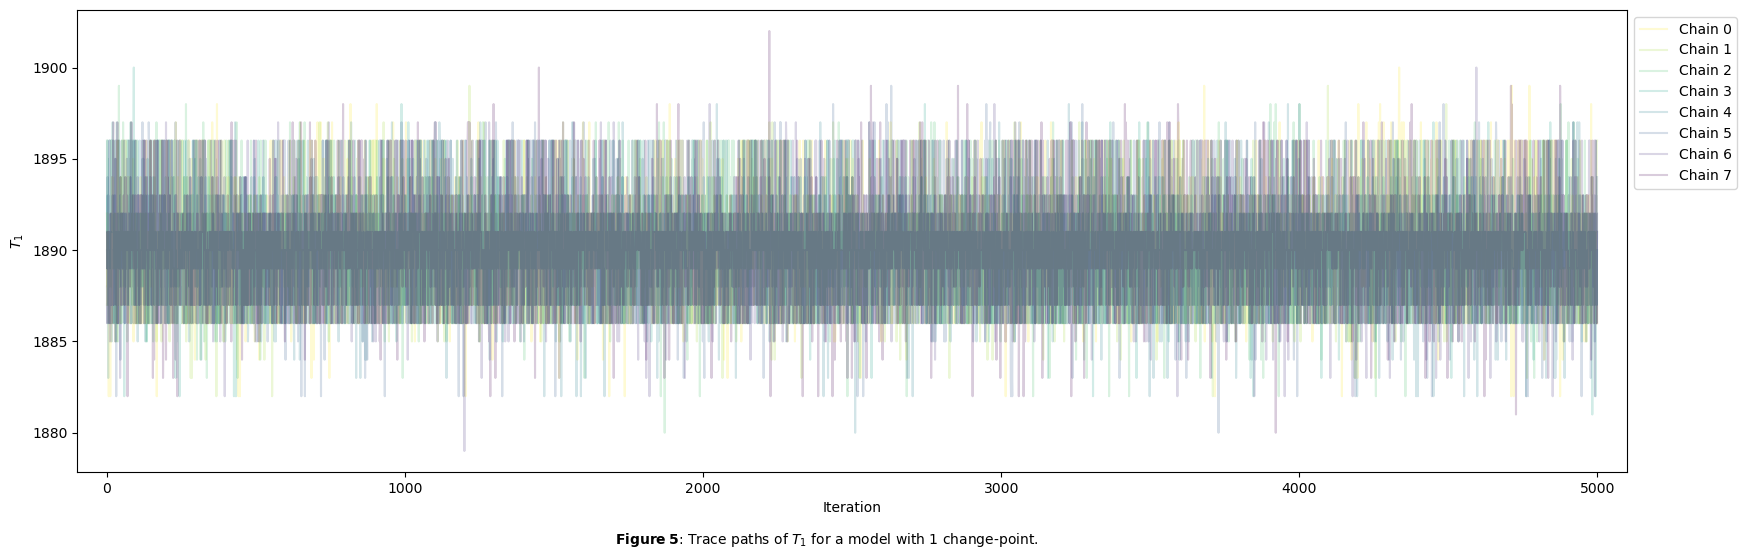

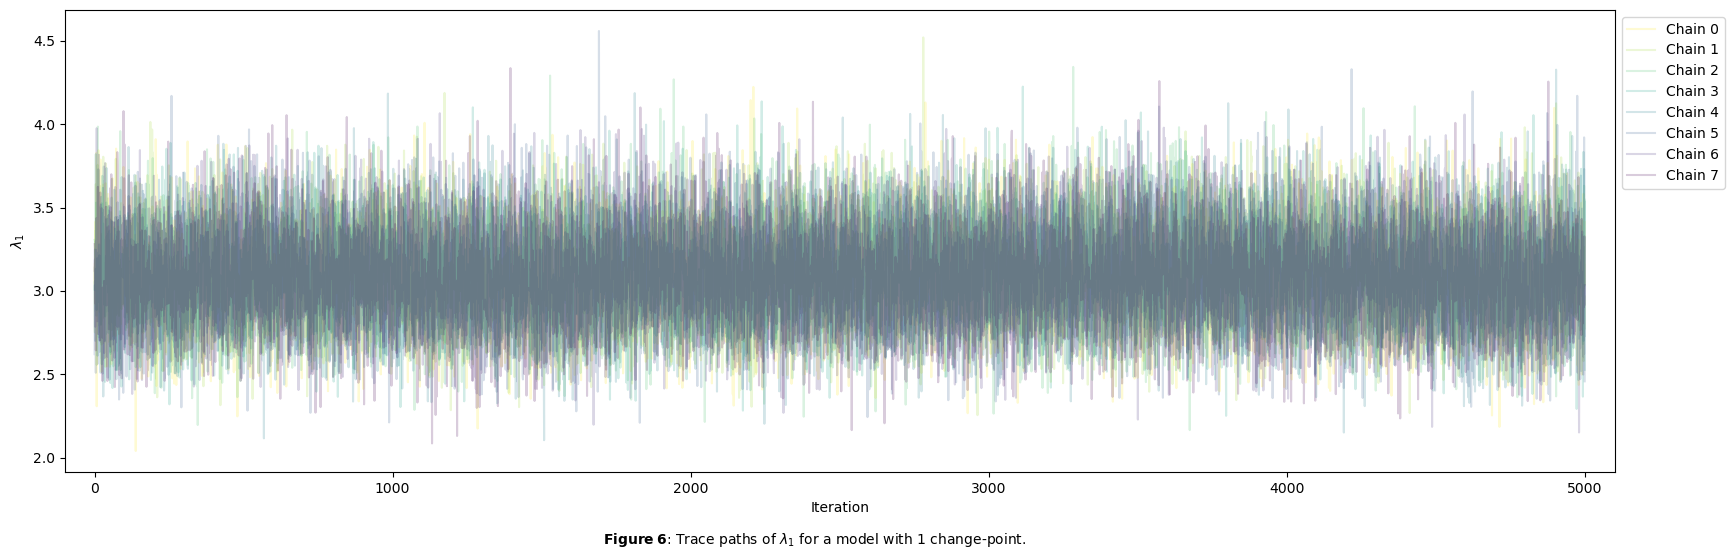

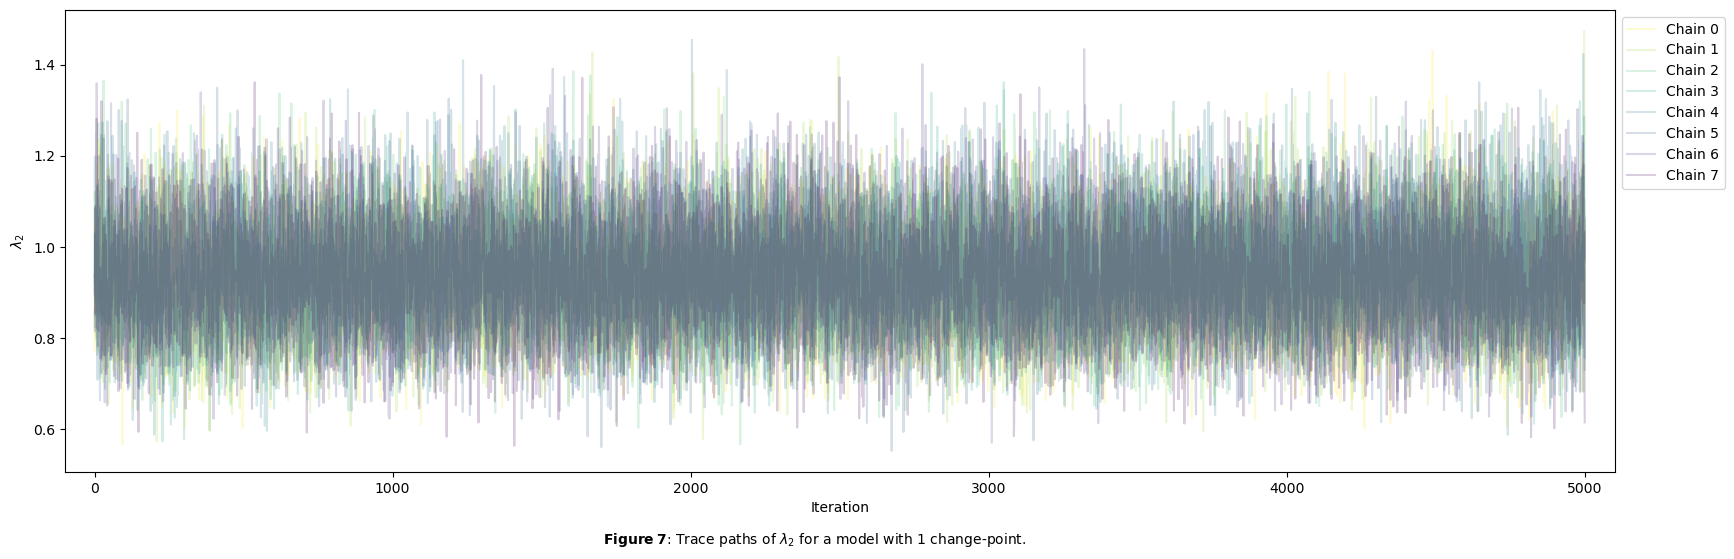

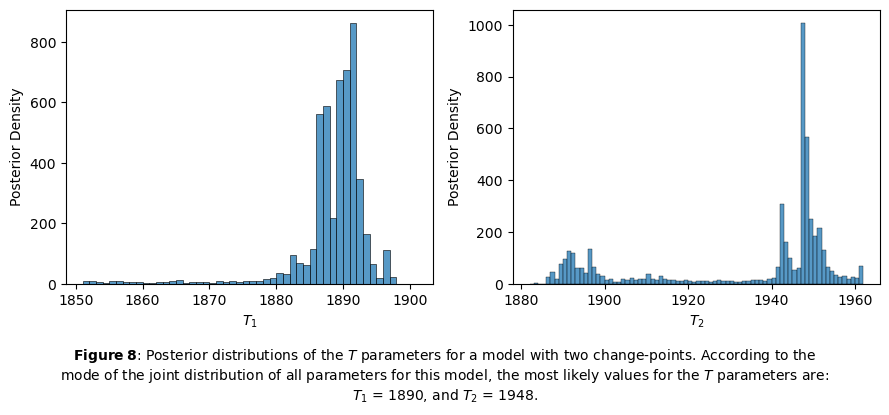

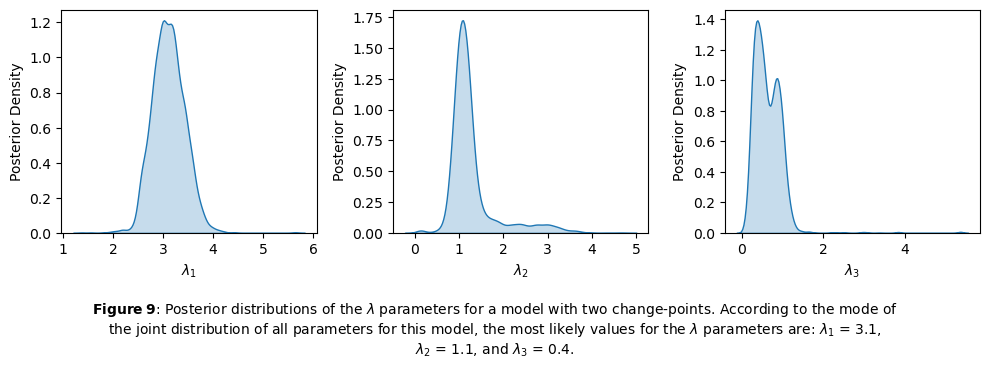

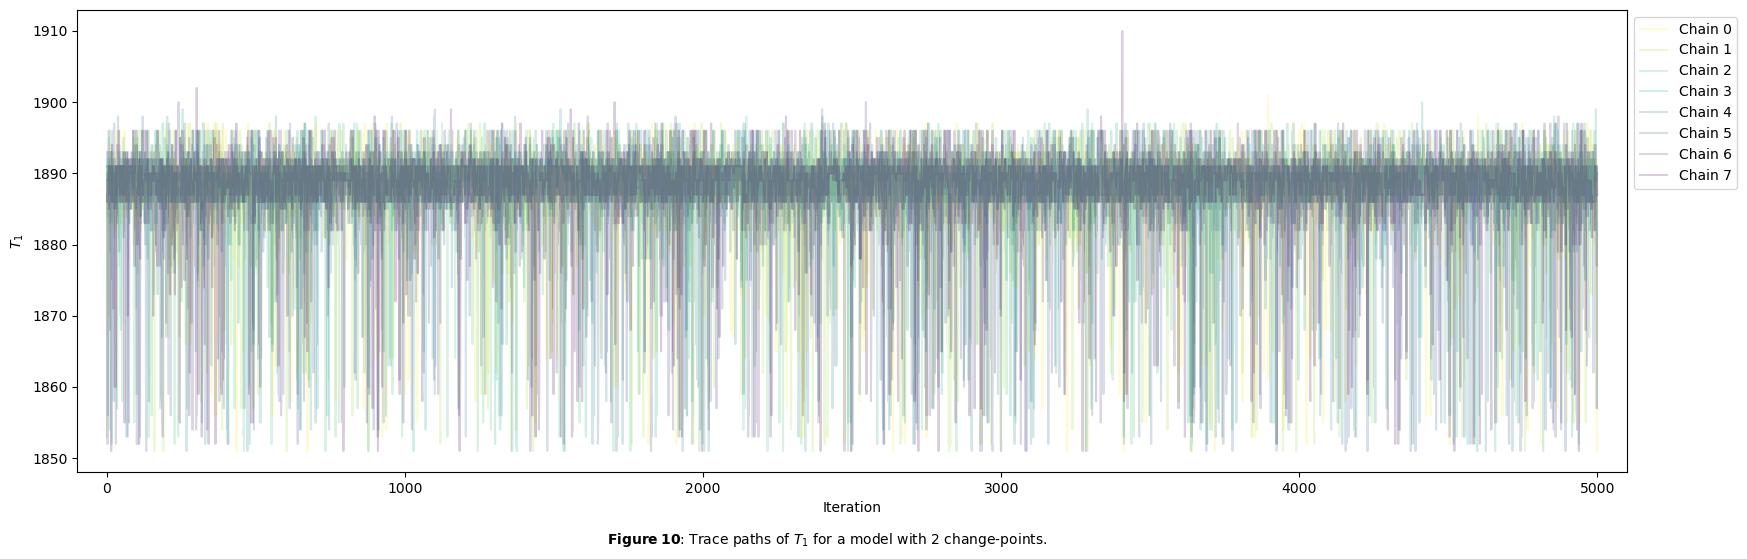

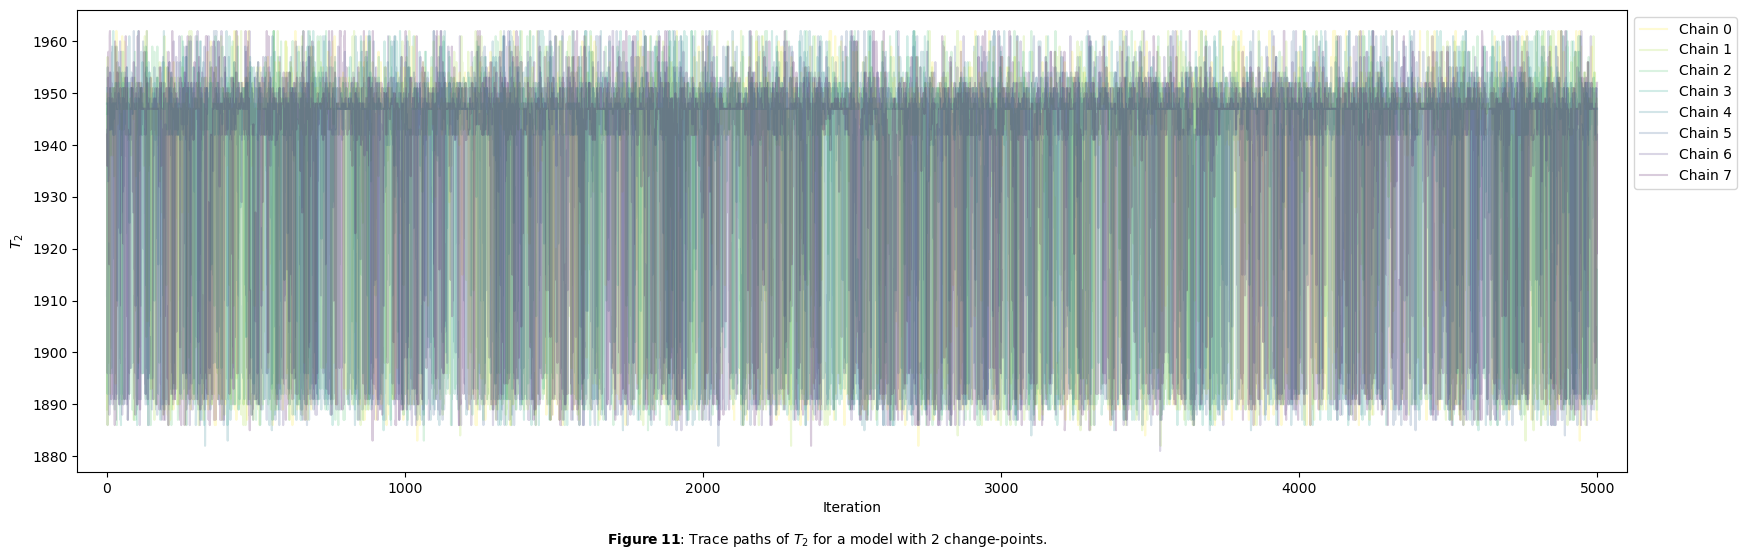

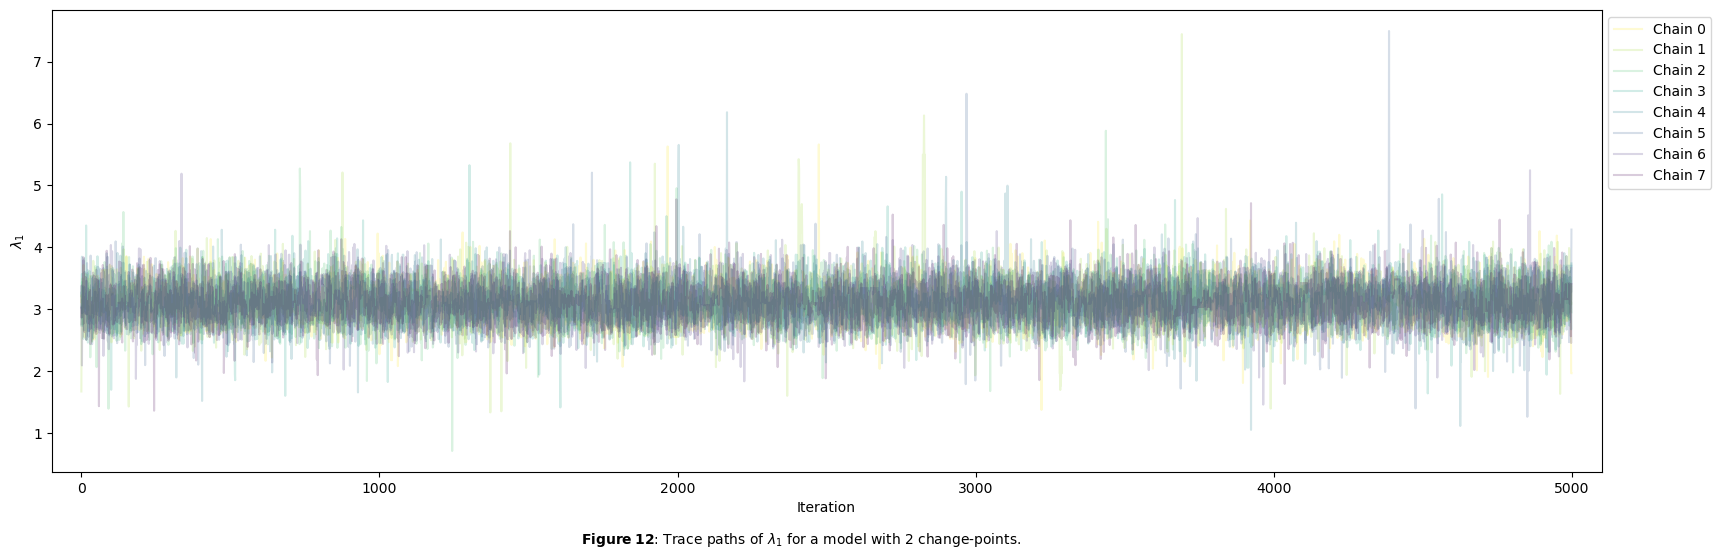

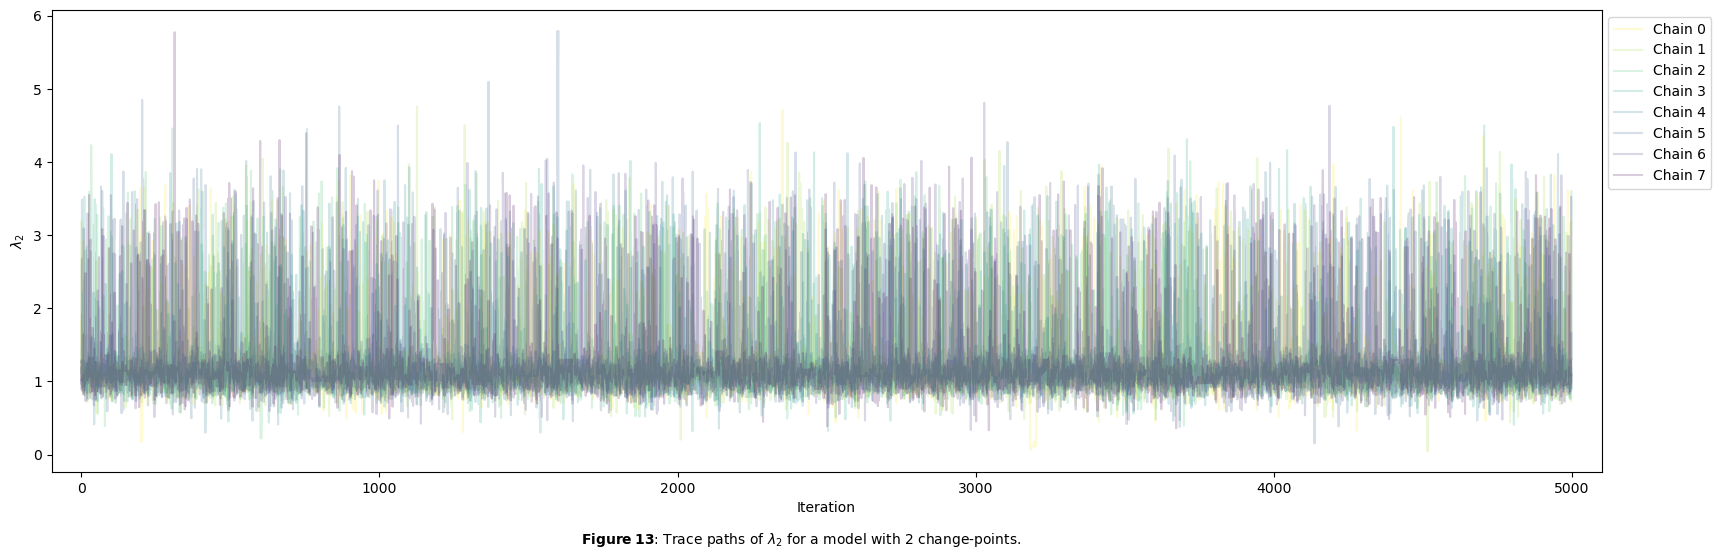

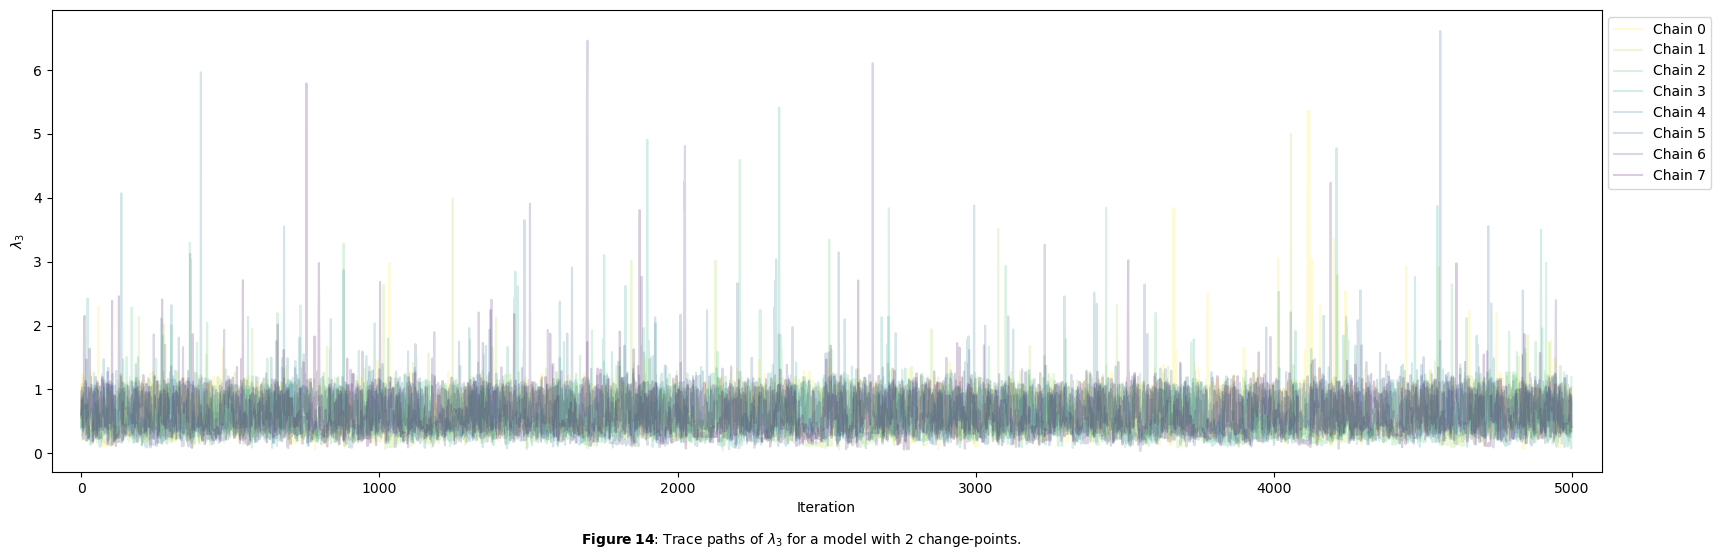

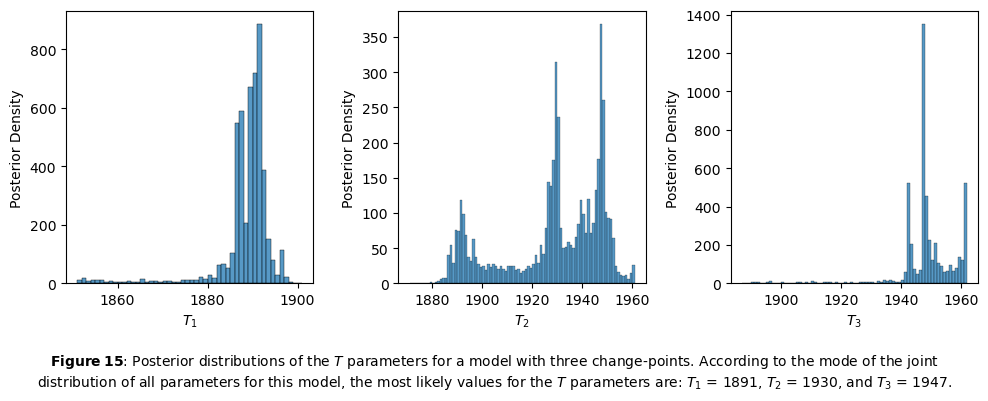

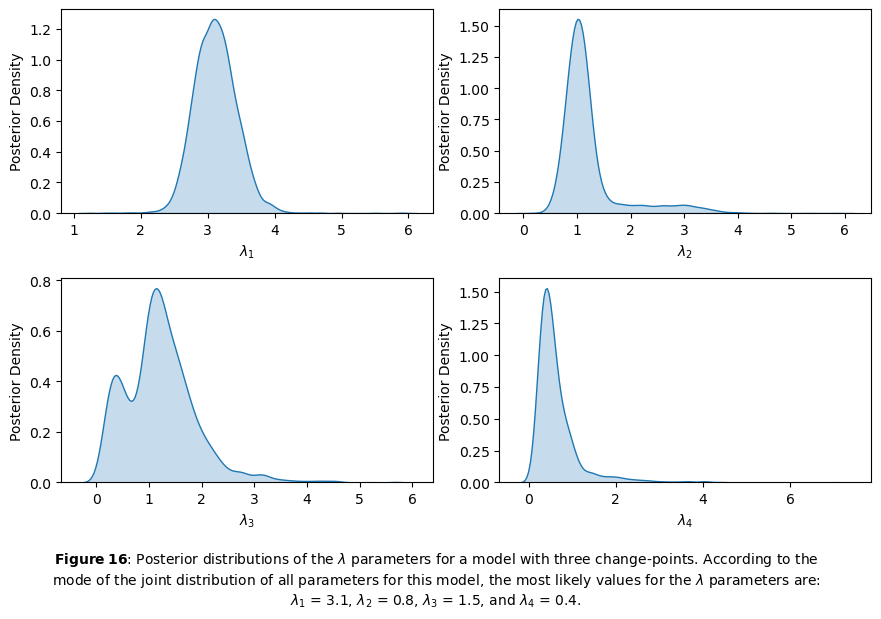

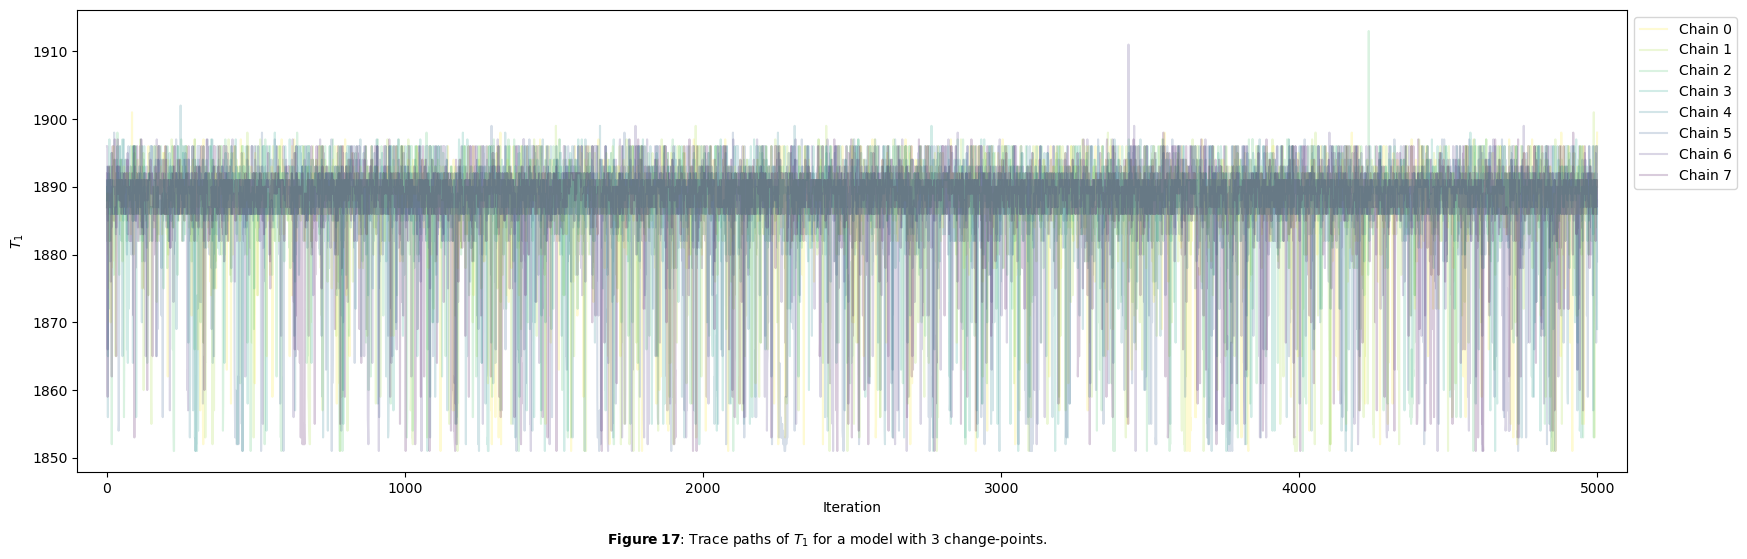

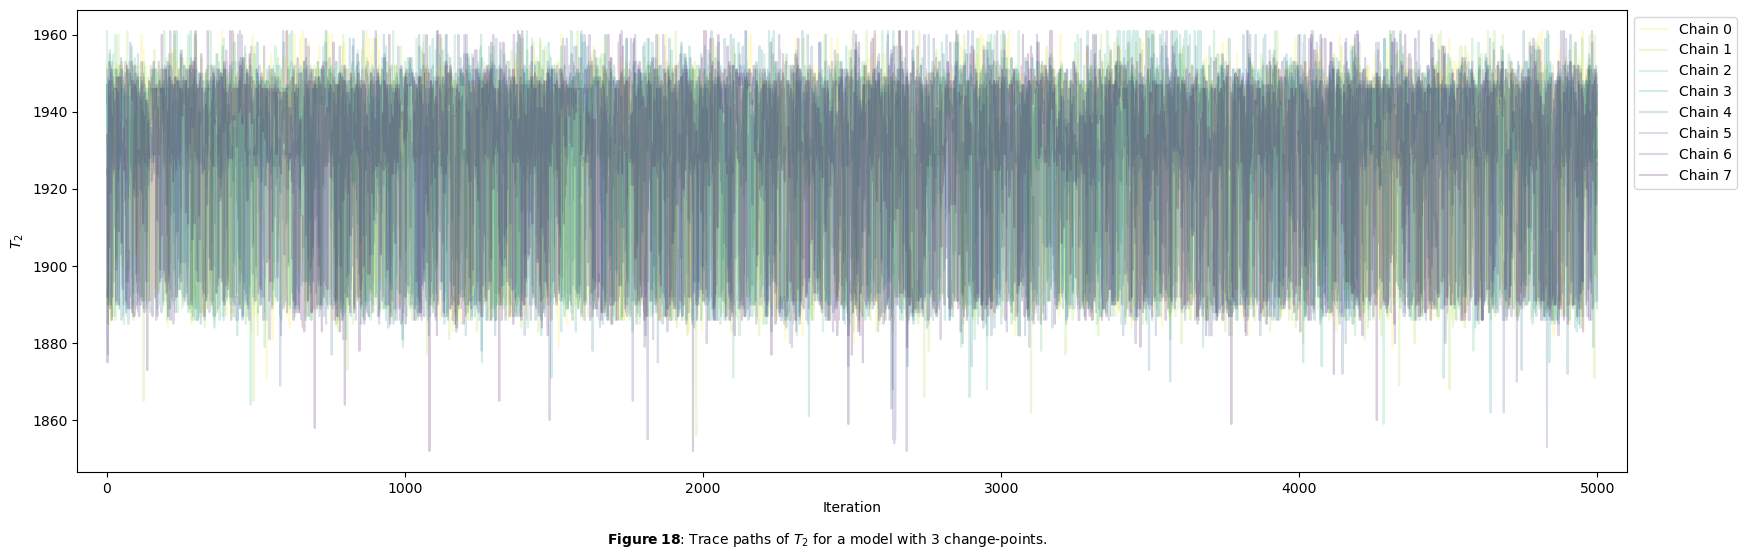

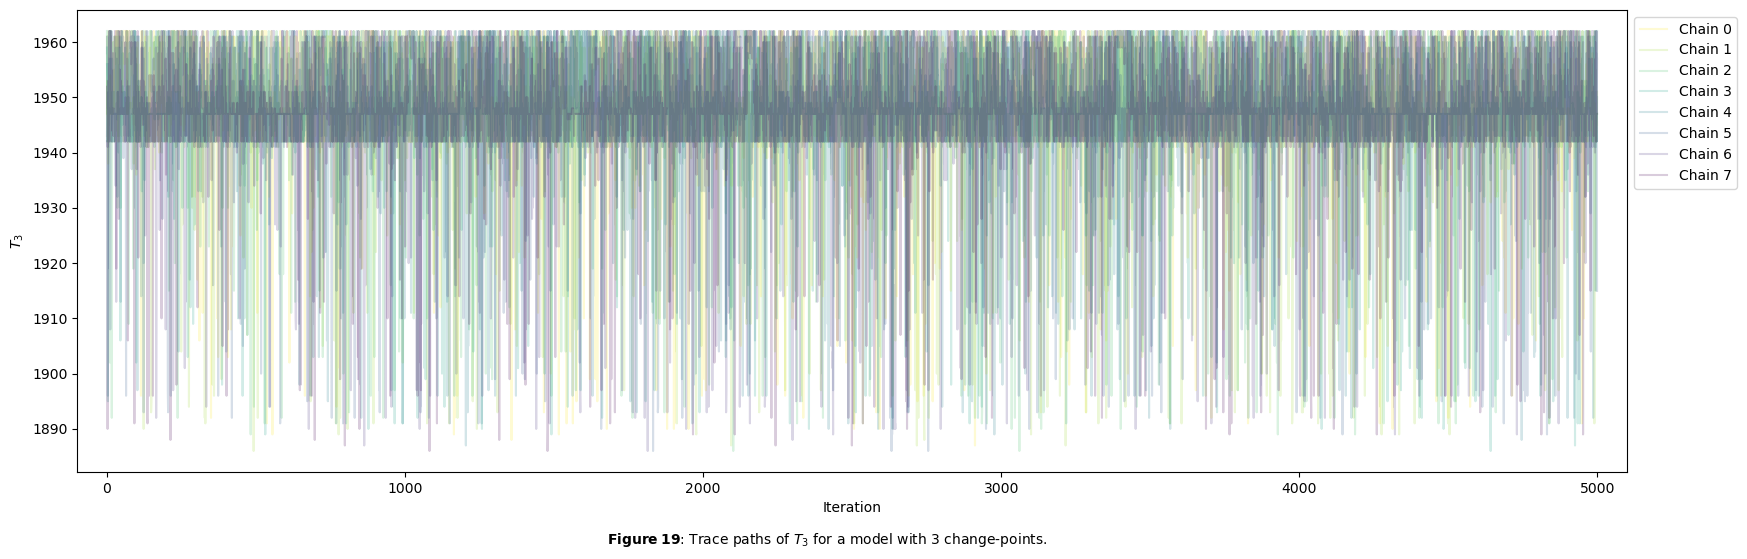

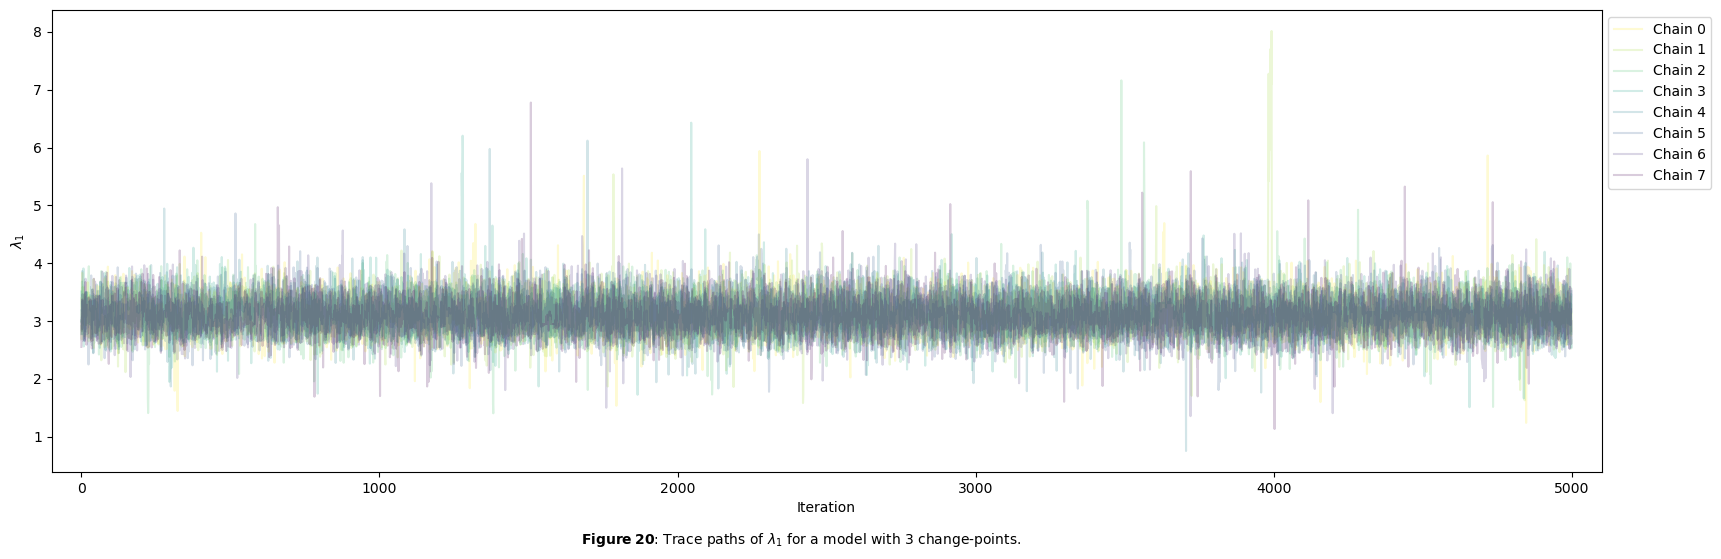

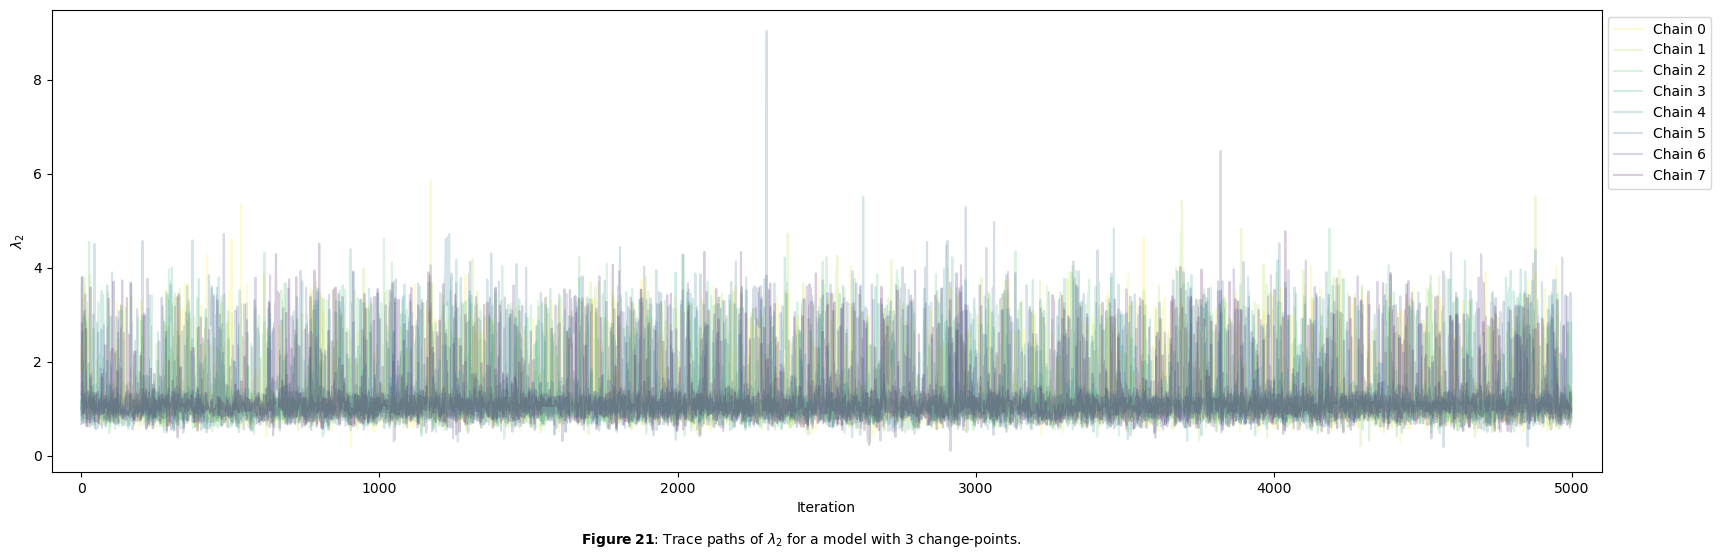

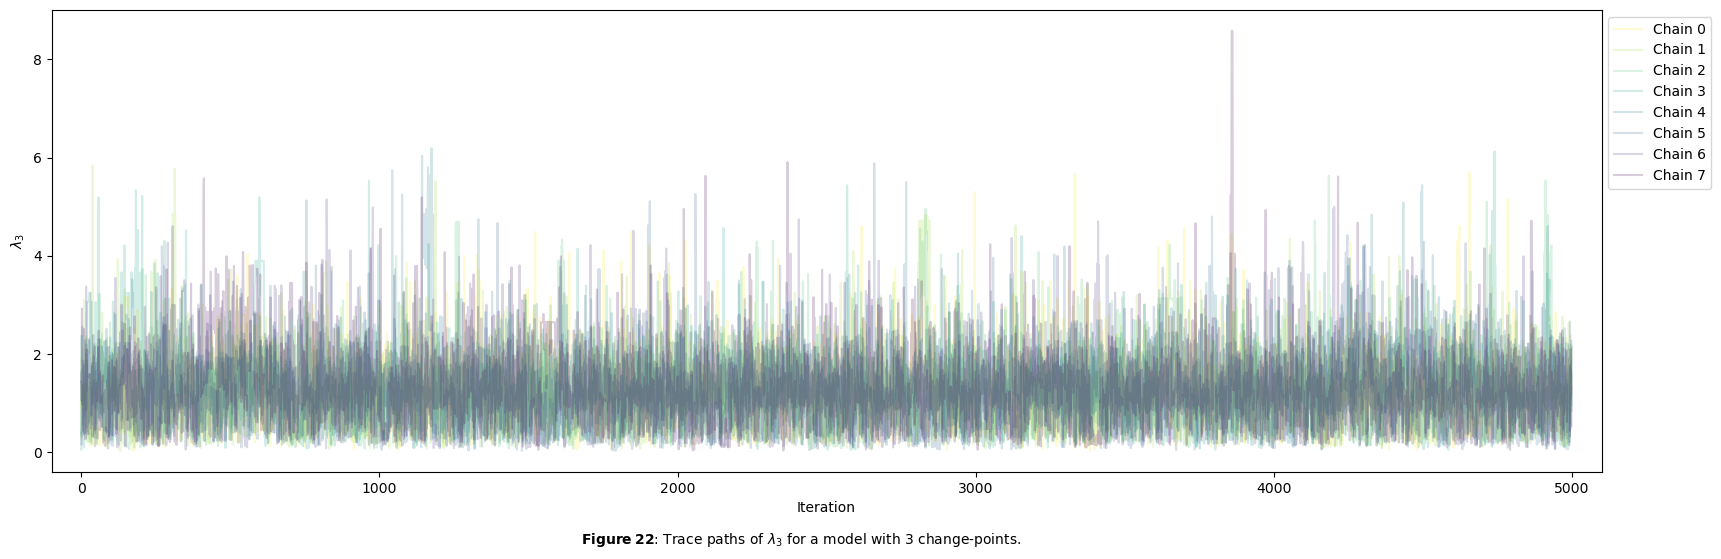

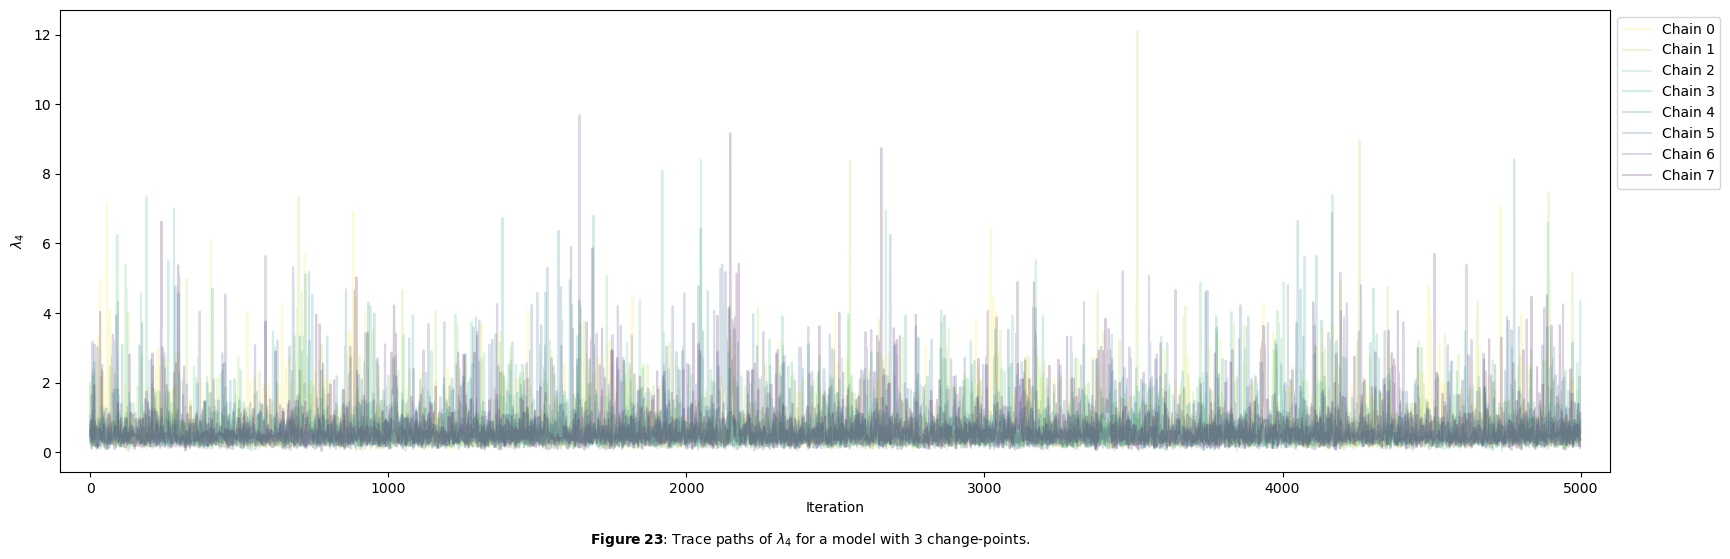

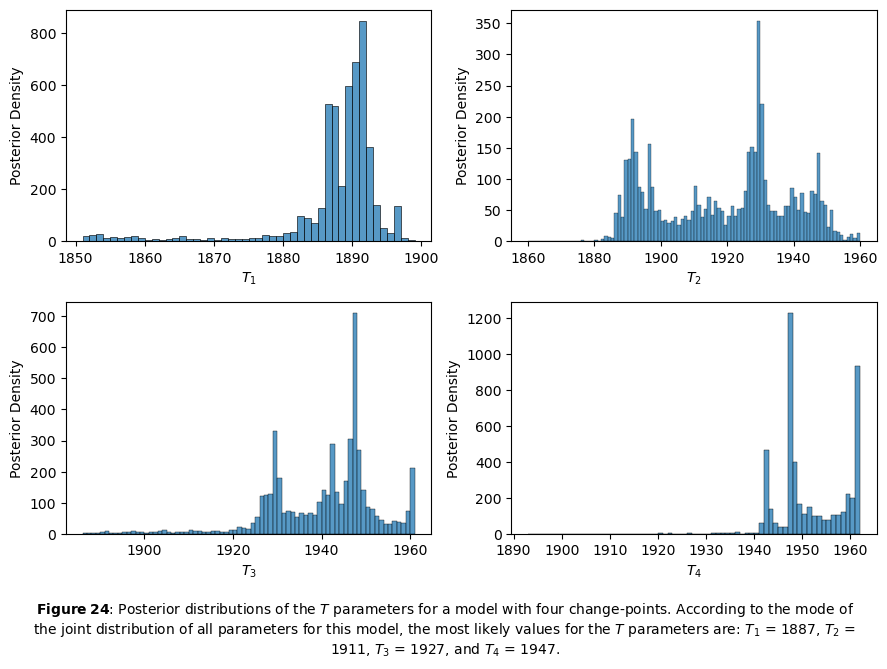

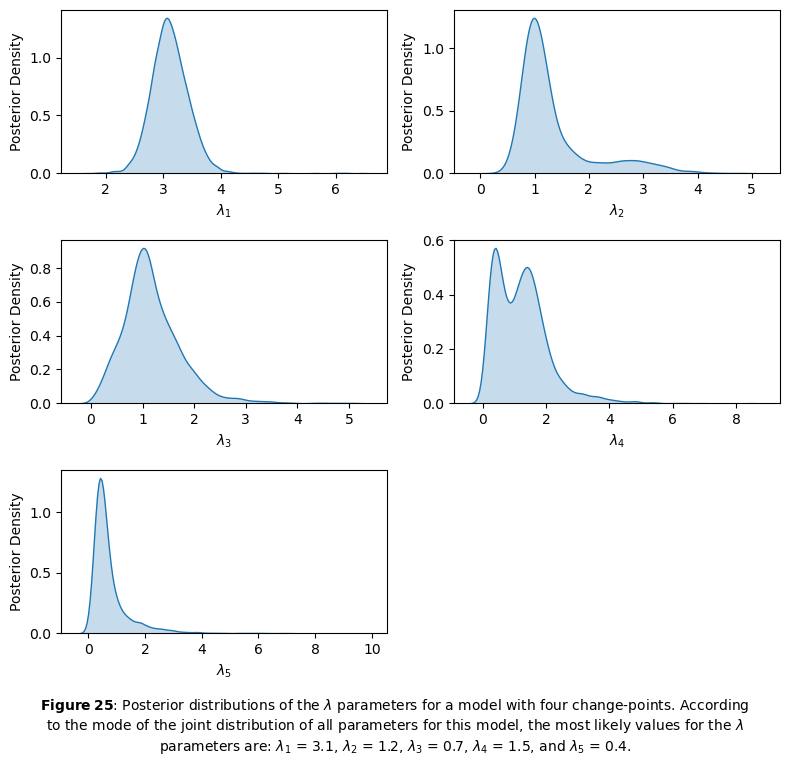

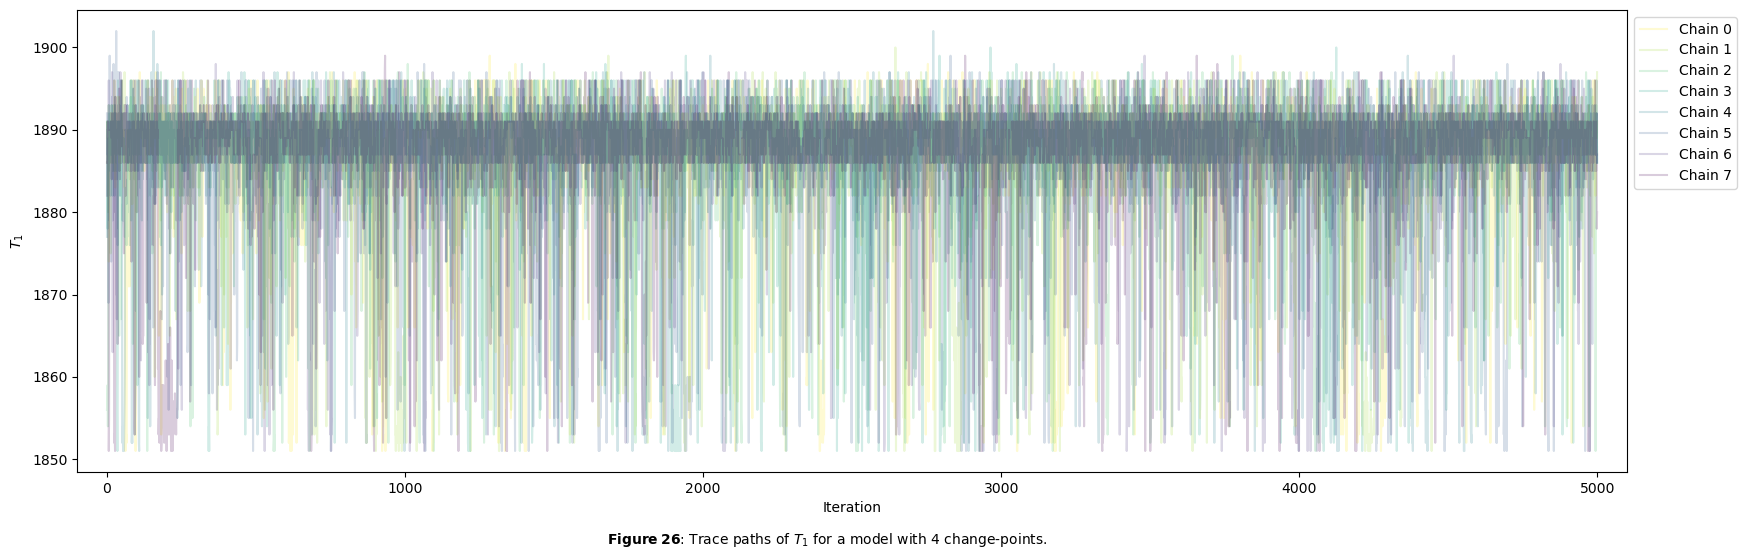

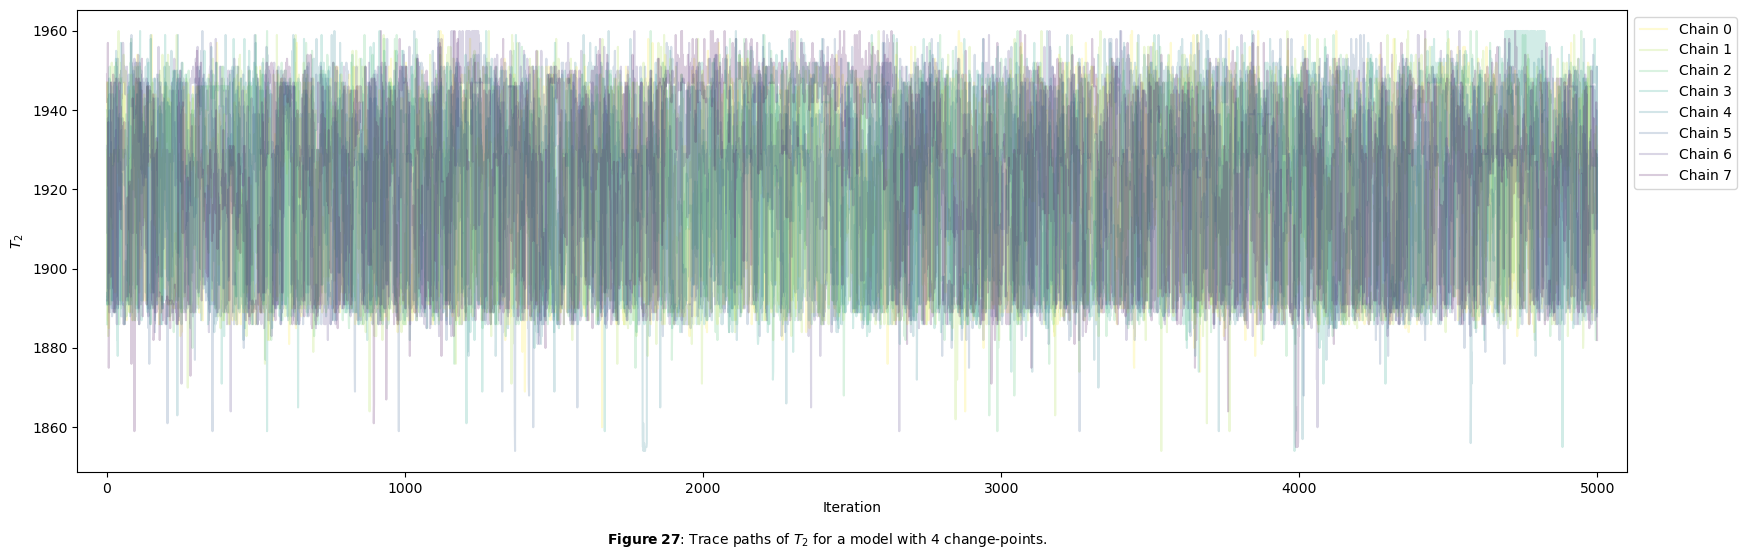

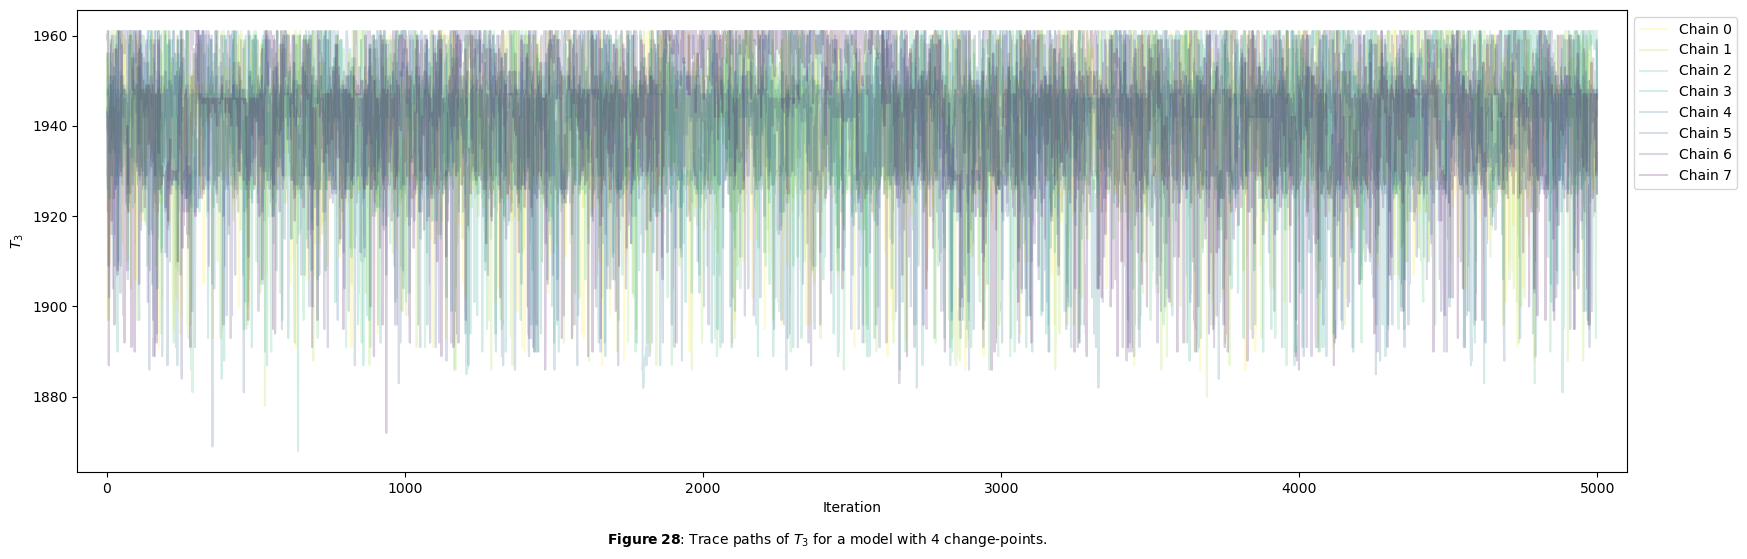

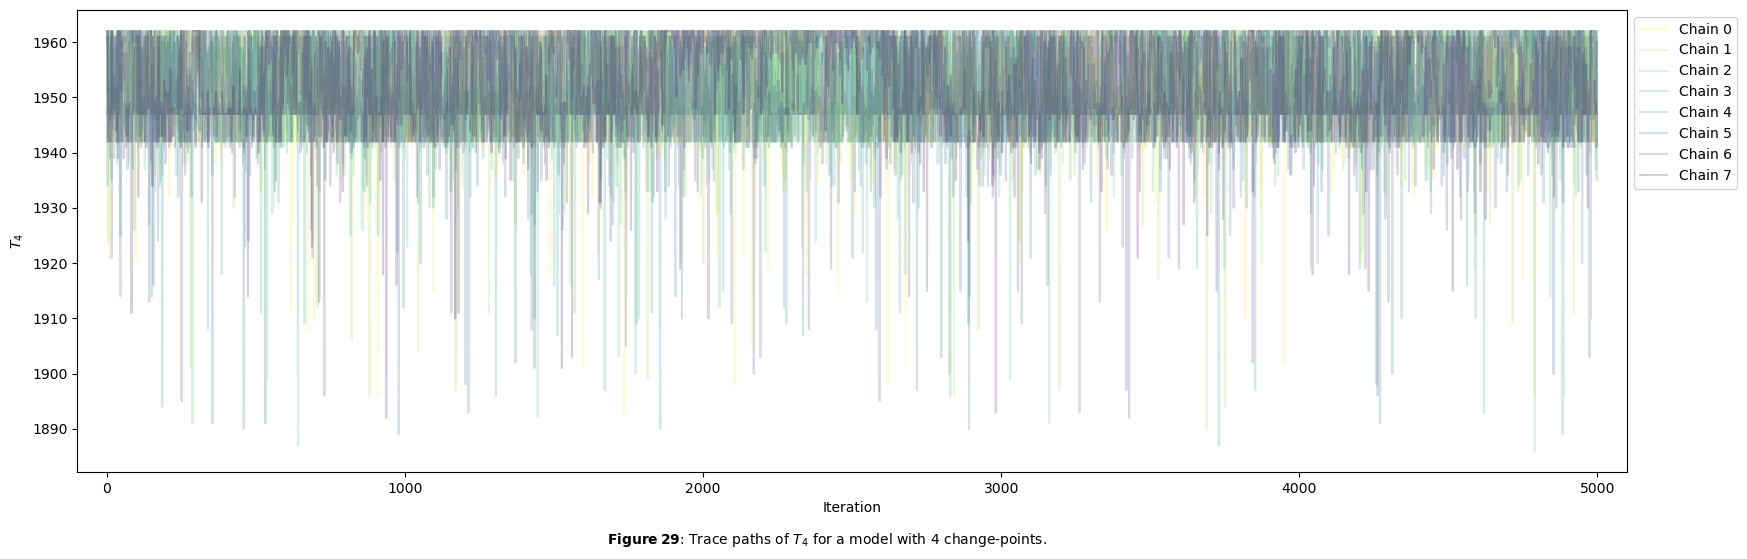

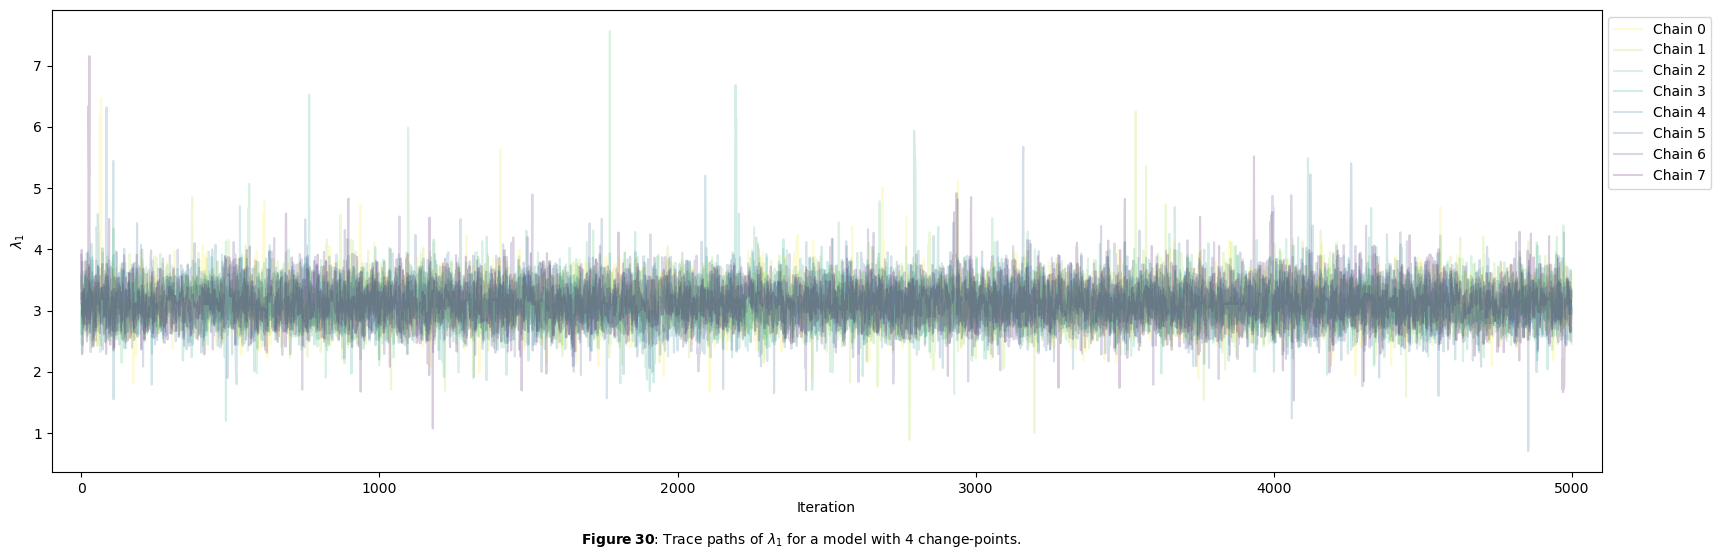

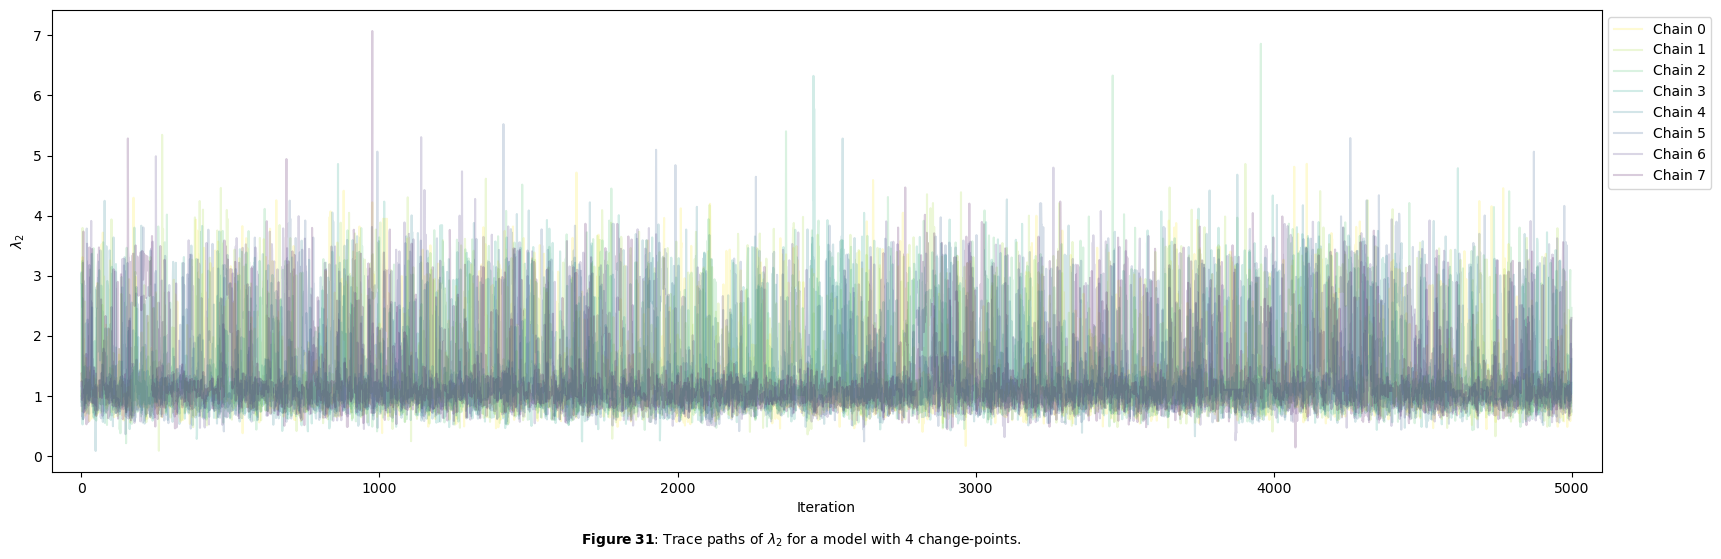

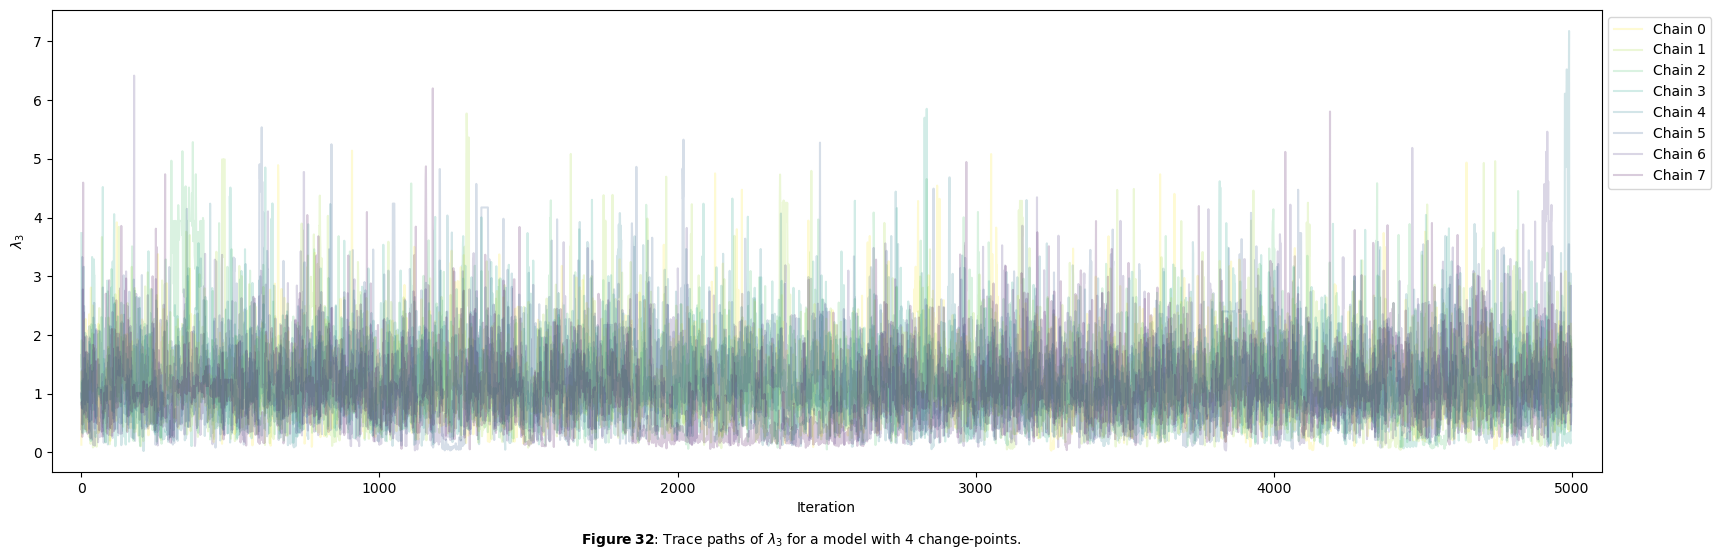

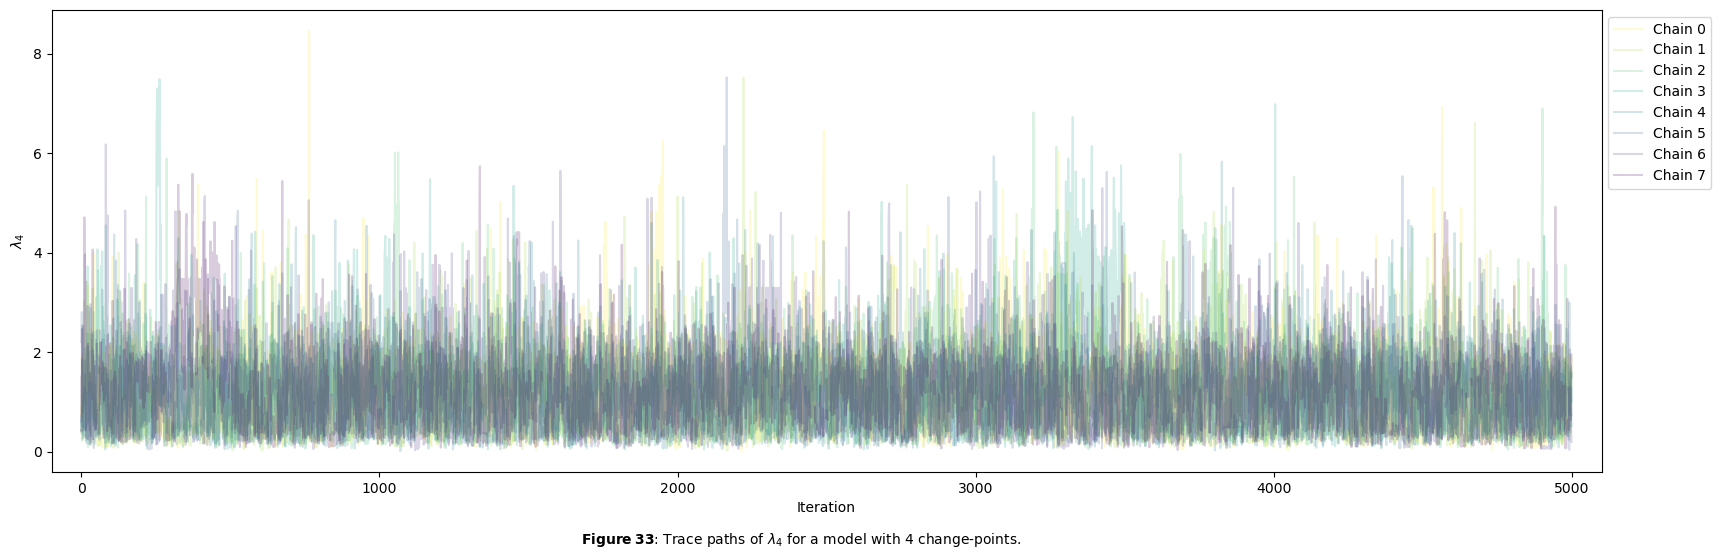

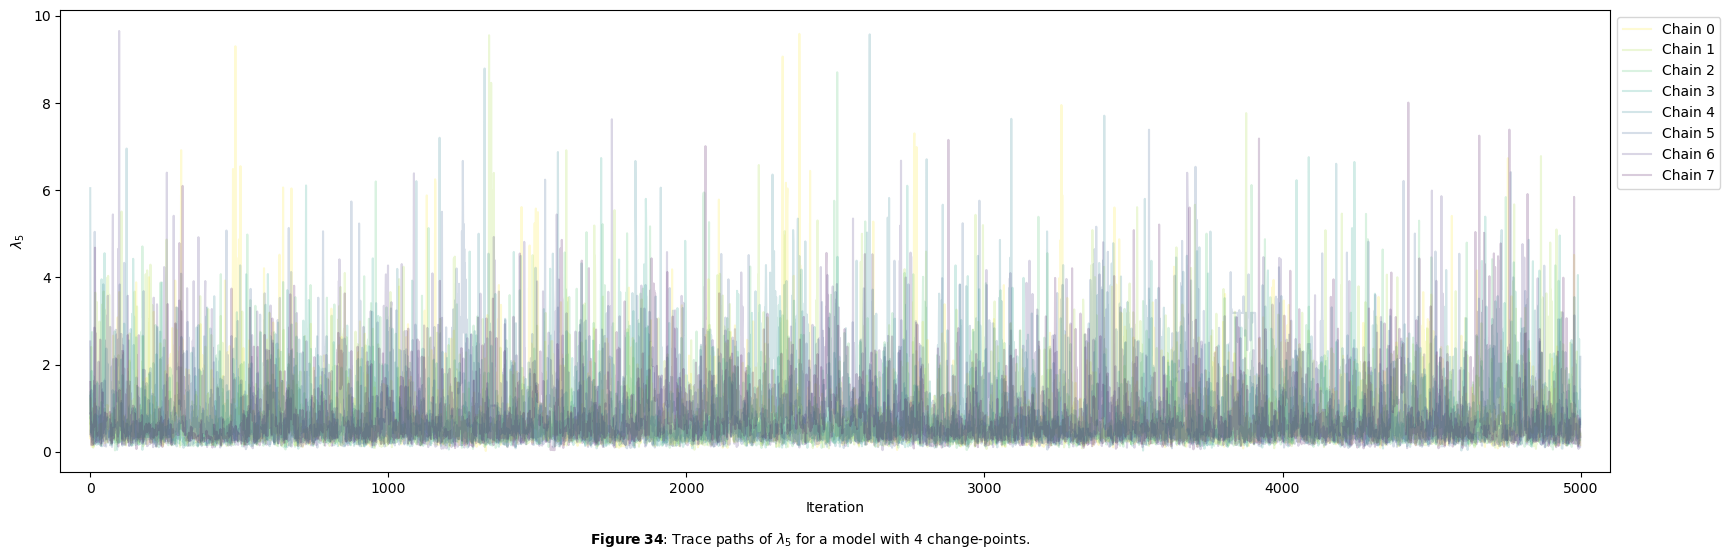

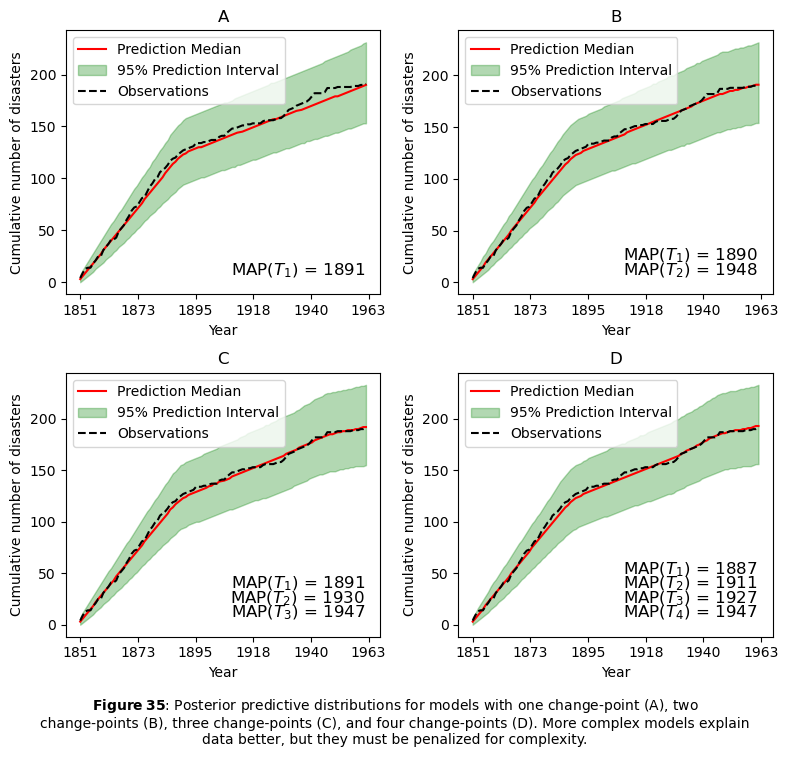

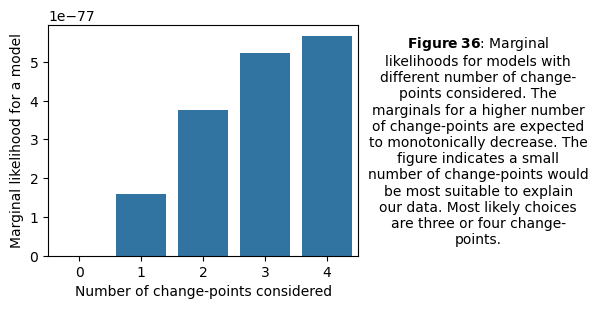

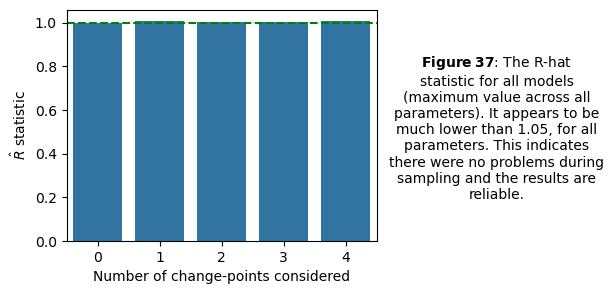

In [17]:
if __name__ == '__main__':
        
    x, y = get_data()
    
    plot_data(x, y)
    
    (
        posterior_trace_0, 
        posterior_predictive_0, 
        rhat_0,
    ) = run_0changepoint_model(y)
    
    (
        posterior_trace_1, 
        posterior_predictive_1, 
        rhat_1,
    ) = run_1changepoint_model(y)

    (
        posterior_trace_2, 
        posterior_predictive_2, 
        rhat_2,
    ) = run_2changepoint_model(y)

    (
        posterior_trace_3, 
        posterior_predictive_3, 
        rhat_3,
    ) = run_3changepoint_model(y)
        
    (
        posterior_trace_4, 
        posterior_predictive_4, 
        rhat_4,
    ) = run_4changepoint_model(y)

    traces = [
        posterior_trace_0, 
        posterior_trace_1, 
        posterior_trace_2, 
        posterior_trace_3, 
        posterior_trace_4,
    ]
    predictions = [
        posterior_predictive_0,
        posterior_predictive_1,
        posterior_predictive_2, 
        posterior_predictive_3, 
        posterior_predictive_4,
    ]
    predictions = [preds['obs'] for preds in predictions]
    
    modes = [get_joint_mode(trace) for trace in traces]

    for i, (trace, mode) in enumerate(zip(traces, modes)):
        if i == 0:
            model_n_plots(trace, mode, y=y, y_pred=predictions[0])
        else:
            model_n_plots(trace, mode)

    plot_predictions(y, predictions[1:], modes[1:])

    marginals = [
        np.exp(np.mean([vec[-1] for vec in trace.report.log_marginal_likelihood])) 
        for trace in traces
    ] 
    plot_marginals(marginals)
    
    metrics = [rhat_0, rhat_1, rhat_2, rhat_3, rhat_4]
    plot_metric(metrics)
